In [29]:
import numpy as np
import torch
from generate_samples import SyntheticDAG
# import generate_samples
from oracle import *
from ssm import *
from torch.func import jacrev, vmap
from stein import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from skopt import gp_minimize
# from skopt.space import Real
# from skopt.utils import use_named_args
from numpy.polynomial.polynomial import Polynomial
from scipy.stats import t
from scipy.optimize import curve_fit

In [2]:
def sample_full_rank_matrix(n=3, lower=-10, upper=10):
    while True:
        matrix = torch.FloatTensor(n, n).uniform_(lower, upper)
        matrix.requires_grad_(True)
        matrix.retain_grad()
        if torch.det(matrix).item() != 0:
            return matrix

In [3]:
def max_diff(x, H_diff_sym):
    max_diff = 0.0
    for mat in H_diff_sym:
        val = np.abs(x@mat@x)
        max_diff = max(max_diff, val)
    return max_diff

In [4]:
def SER(true_matrices, estimated_matrices):
    total_true_norm = sum(np.linalg.norm(A, 'fro')**2 for A in true_matrices)
    total_error_norm = sum(np.linalg.norm(A - A_hat, 'fro')**2 for A, A_hat in zip(true_matrices, estimated_matrices))
    global_SER = total_true_norm / total_error_norm
    global_SER_dB = 10 * np.log10(global_SER)
    return global_SER, global_SER_dB

def perturb(true_matrices, desired_SER_dB):
    # Convert SER dB to linear scale
    desired_SER_linear = 10 ** (desired_SER_dB / 10)

    # Calculate total signal power
    total_true_norm = sum(np.linalg.norm(A, 'fro')**2 for A in true_matrices)

    # Calculate total noise power based on desired SER
    total_noise_power = total_true_norm / desired_SER_linear

    # Number of matrices
    n_matrices = len(true_matrices)

    # Calculate individual noise power if equally distributed
    individual_noise_power = total_noise_power / n_matrices
    # Generate noise matrices and estimated matrices
    noise_matrices = []
    estimated_matrices = []

    for A in true_matrices:
        # Generate random noise matrix
        noise = np.random.randn(*A.shape)
        # Scale the noise to have the correct Frobenius norm
        noise_norm = np.linalg.norm(noise, 'fro')
        scaled_noise = noise * (np.sqrt(individual_noise_power) / noise_norm)
        noise_matrices.append(scaled_noise)
        # Add noise to the true matrix to create the estimated matrix
        estimated_matrices.append(A + scaled_noise)

    return estimated_matrices


In [5]:
DAG_type = 'line'
num_latent = 4
num_samples = 2000
lower_G = -1 #min possibel value in G or G_hat
upper_G = 1 #max possible value in G or G_hat

In [6]:
graph = SyntheticDAG(num_latent, DAG_type)
G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
U,X,noises = graph.sample_scaled(G, 3000)

In [7]:
J_X_true = H_X(graph, U, G).detach().numpy()

In [8]:
J_X_est = Stein_hess_mat(X).detach().numpy()

In [22]:
df = pd.read_csv('tests/SER_test.csv')

# Assuming the first column is SER and the rest are MAC measurements
SER = df.iloc[:, 0]
MAC_measurements = df.iloc[:, 1:] 

MAC_mean = MAC_measurements.mean(axis=1)
MAC_std = MAC_measurements.std(axis=1)
MAC_se = MAC_std / np.sqrt(MAC_measurements.shape[1])

# Define the smoothing factor alpha
alpha = 0.25  # Alpha can be between 0 and 1

# Apply exponential smoothing
smoothed_MAC_mean = MAC_mean.ewm(alpha=alpha, adjust=False).mean()
smoothed_upper = (MAC_mean + MAC_se).ewm(alpha=alpha, adjust=False).mean()
smoothed_lower = (MAC_mean - MAC_se).ewm(alpha=alpha, adjust=False).mean()

# Optionally, fill NaN values if there are any at the start
smoothed_MAC_mean = smoothed_MAC_mean.fillna(method='bfill')
smoothed_upper = smoothed_upper.fillna(method='bfill')
smoothed_lower = smoothed_lower.fillna(method='bfill')

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(SER, smoothed_MAC_mean, label='Smoothed MAC', color='blue')
plt.fill_between(SER, smoothed_lower, smoothed_upper, color='blue', alpha=0.3, label='Confidence Interval')

y_lower, y_upper = plt.ylim()
ssm_location = 5.6768695599372725  # the x-coordinate where the line should be drawn
plt.axvline(x=ssm_location, color='red', linestyle=':', linewidth=2)
y_mid_h = y_lower + 0.75 * (y_upper - y_lower)
plt.text(ssm_location, y_mid_h, '  SSM', color='red', verticalalignment='center', horizontalalignment='left', fontsize=12)

stein_location = 2.0122194828233173
plt.axvline(x=stein_location, color='black', linestyle=':', linewidth=2)
y_mid_l = y_lower + 0.25 * (y_upper - y_lower)
plt.text(stein_location, y_mid_l, '  STEIN', color='black', verticalalignment='center', horizontalalignment='left', fontsize=12)

plt.title('Smoothed MAC vs SER')
plt.xlabel('SER (dB)')
plt.ylabel('MAC')
plt.grid(True)
plt.legend()
plt.show()


/var/folders/4w/ydwt6t6121q_3f2yzbm6znww0000gn/T/ipykernel_31095/57530121.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_MAC_mean = smoothed_MAC_mean.fillna(method='bfill')
/var/folders/4w/ydwt6t6121q_3f2yzbm6znww0000gn/T/ipykernel_31095/57530121.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_upper = smoothed_upper.fillna(method='bfill')
/var/folders/4w/ydwt6t6121q_3f2yzbm6znww0000gn/T/ipykernel_31095/57530121.py:22: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  smoothed_lower = smoothed_lower.fillna(method='bfill')


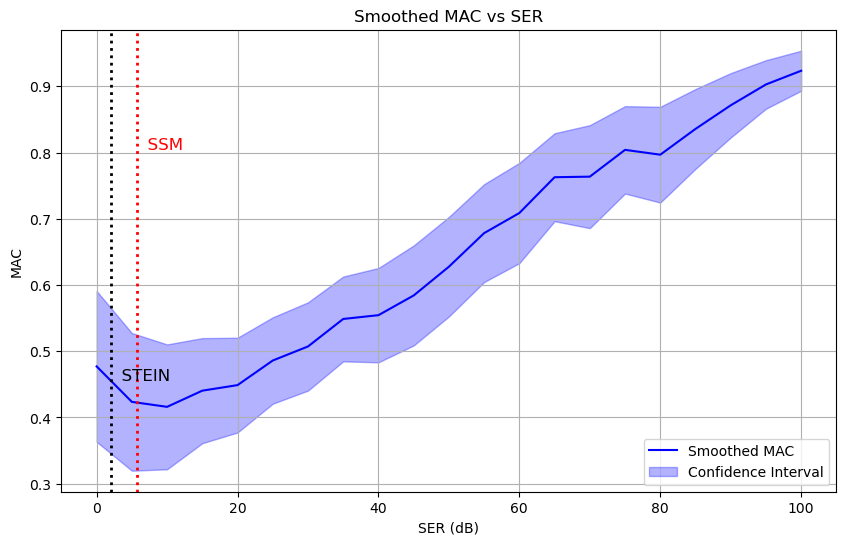

In [23]:
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(SER, smoothed_MAC_mean, label='Smoothed MAC', color='blue')
plt.fill_between(SER, smoothed_lower, smoothed_upper, color='blue', alpha=0.3, label='Confidence Interval')

y_lower, y_upper = plt.ylim()
ssm_location = 5.6768695599372725  # the x-coordinate where the line should be drawn
plt.axvline(x=ssm_location, color='red', linestyle=':', linewidth=2)
y_mid_h = y_lower + 0.75 * (y_upper - y_lower)
plt.text(ssm_location, y_mid_h, '  SSM', color='red', verticalalignment='center', horizontalalignment='left', fontsize=12)

stein_location = 2.0122194828233173
plt.axvline(x=stein_location, color='black', linestyle=':', linewidth=2)
y_mid_l = y_lower + 0.25 * (y_upper - y_lower)
plt.text(stein_location, y_mid_l, '  STEIN', color='black', verticalalignment='center', horizontalalignment='left', fontsize=12)

plt.title('Smoothed MAC vs SER')
plt.xlabel('SER (dB)')
plt.ylabel('MAC')
plt.grid(True)
plt.legend()
plt.show()

In [11]:
STEIN_SER = []

for i  in range(10):
    print(i)
    graph = SyntheticDAG(num_latent, DAG_type)
    G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)
    U,X,noises = graph.sample_scaled(G, 3000)
    J_X_true = H_X(graph, U, G).detach().numpy()
    J_X_est = Stein_hess_mat(X).detach().numpy()
    ser = SER(J_X_true, J_X_est)
    print(ser)
    STEIN_SER.append(ser)

0
(2.284307951368626, 3.587546514848091)
1
(0.5106740713277664, -2.9185619220347876)
2
(3.3998010604118947, 5.314535050148727)
3
(2.275087819598887, 3.5699816531448785)
4
(4.510182552465634, 6.541941205750728)
5
(3.2232998927343206, 5.083007137347069)
6
(0.535092902433524, -2.715708095460187)
7
(0.5434663213780109, -2.6482736398408786)
8
(0.8548577686882336, -0.6810613721596874)
9
(2.6849120859179814, 4.289300698397519)


In [12]:
np.mean(np.array(STEIN_SER))

2.0122194828233173

In [45]:
graph = SyntheticDAG(num_latent, DAG_type)
G = sample_full_rank_matrix(num_latent, lower_G, upper_G)+torch.eye(num_latent)

In [39]:
U_tr,X_tr,noises_tr = graph.sample_scaled(G, num_samples+50000)

In [30]:
indices = np.random.choice(num_samples+200000, num_samples, replace=False)
U = U_tr[indices]
X = X_tr[indices]
noises = noises_tr[indices]

# True Scores

In [31]:
HX = H_X(graph, U, G)

In [32]:
HX

tensor([[[-100.5908,   64.7829,  -23.5792,   16.8269],
         [  64.7829,  -56.8447,   10.0026,  -22.8202],
         [ -23.5792,   10.0026,  -11.1872,    2.5786],
         [  16.8269,  -22.8202,    2.5786,  -14.2064]],

        [[ -76.8548,   58.9499,  -10.7810,   12.9636],
         [  58.9499,  -54.5371,    5.4258,  -20.0375],
         [ -10.7810,    5.4258,   -7.5050,    0.8281],
         [  12.9636,  -20.0375,    0.8281,  -16.6279]],

        [[ -58.0064,   53.8018,   -0.2742,   15.5780],
         [  53.8018,  -53.9932,    1.1192,  -18.3914],
         [  -0.2742,    1.1192,   -3.6884,    3.6601],
         [  15.5780,  -18.3914,    3.6601,  -14.7496]],

        ...,

        [[ -54.4101,   56.0836,   -1.4310,   19.9175],
         [  56.0836,  -74.5910,   -8.0969,  -27.3333],
         [  -1.4310,   -8.0969,  -11.0930,   -1.0953],
         [  19.9175,  -27.3333,   -1.0953,  -24.8393]],

        [[-104.6005,   64.3595,  -22.3709,   12.2263],
         [  64.3595,  -49.1925,   11.3695, 

In [33]:
ssm_hess(X, X_tr, score_est_steps=100)

tensor([[[-1.0405e+02,  6.9161e+01, -2.2540e+01,  1.8286e+01],
         [ 6.2479e+01, -5.4060e+01,  9.0848e+00, -2.0934e+01],
         [-2.3959e+01,  1.2671e+01, -1.1638e+01,  5.2754e+00],
         [ 1.7573e+01, -2.1536e+01,  4.0781e+00, -1.3839e+01]],

        [[-6.2941e+01,  5.1378e+01, -6.0017e+00,  1.0213e+01],
         [ 5.1035e+01, -4.7762e+01,  3.9503e+00, -1.7785e+01],
         [-6.3146e+00,  4.6114e+00, -4.9663e+00,  4.4723e-01],
         [ 9.2426e+00, -1.6245e+01, -1.5362e-01, -1.4549e+01]],

        [[-6.9131e+01,  5.8998e+01, -2.6210e+00,  1.6325e+01],
         [ 5.7124e+01, -5.2632e+01,  2.4830e+00, -1.6273e+01],
         [-4.3006e+00,  4.3069e+00, -4.5528e+00,  5.3189e+00],
         [ 1.5567e+01, -1.5859e+01,  4.4963e+00, -1.4151e+01]],

        ...,

        [[-6.8067e+01,  6.5395e+01, -4.5112e+00,  2.3721e+01],
         [ 6.0340e+01, -7.1039e+01, -2.9796e+00, -2.7684e+01],
         [-7.2934e+00,  4.8932e-01, -8.6298e+00,  1.2340e+00],
         [ 2.3421e+01, -2.9248e+01,

# Stein Estimation

In [9]:
def hessian_col(X_diff, G, col, eta, K, s):
    # Stein estimate
    Gv = torch.einsum("i,ij->ij", G[:, col], G)
    nabla2vK = torch.einsum("ik,ikj,ik->ij", X_diff[:, :, col], X_diff, K) / s**4
    nabla2vK[:, col] -= torch.einsum("ik->i", K) / s**2
    H_col = -Gv + torch.matmul(torch.inverse(K + eta * torch.eye(X_diff.shape[0], dtype=X_diff.dtype, device=X_diff.device)), nabla2vK)
    return H_col

def Stein_hess_mat(X, eta_G=0.01, eta_H=0.01, length_scale=1.0, sigma=1.0, nu=1.5):
    n, d = X.shape
    s = heuristic_kernel_width(X.detach())
    X_diff = X.unsqueeze(1) - X
    K = matern_kernel(X, length_scale, sigma, nu)
    nablaK = matern_kernel_gradient(X, length_scale, sigma, nu)
    # nablaK = degree * alpha * (alpha * dot_products + c)**(degree - 1) * X_diff
    G = torch.matmul(torch.inverse(K + eta_G * torch.eye(n, dtype=X.dtype, device=X.device)), nablaK)

    # Compute the Hessian by column stacked together
    H = torch.stack([hessian_col(X_diff, G, col, eta_H, K, s) for col in range(d)], dim=0)
    return H.transpose(0, 1)

def matern_kernel(X, length_scale=1.0, sigma=1.0, nu=1.5):
    X_diff = X.unsqueeze(1) - X.unsqueeze(0)  # [n, n, d]
    distances = torch.sqrt((X_diff ** 2).sum(-1))  # [n, n], Euclidean distance
    
    if nu == 1.5:
        # Matérn 3/2 Kernel
        scaling = (np.sqrt(3) * distances) / length_scale
        K = sigma ** 2 * (1 + scaling) * torch.exp(-scaling)
    return K

def matern_kernel_gradient(X, length_scale=1.0, sigma=1.0, nu=1.5):
    """ Computes the gradient of the Matérn kernel with nu=3/2 across all data points. """
    n, d = X.shape
    X_diff = X.unsqueeze(1) - X.unsqueeze(0)  # Shape [n, n, d]
    distances = torch.sqrt((X_diff ** 2).sum(-1) + 1e-6)

    sqrt_3 = np.sqrt(3.0)
    scaling = (sqrt_3 * distances) / length_scale
    exp_component = torch.exp(-scaling)

    # Avoid division by zero for zero distances
    gradient_prefactor = (-3 * sqrt_3 / (length_scale**2)) * exp_component / distances
    gradient_prefactor[distances <= 1e-6] = 0

    nablaK = gradient_prefactor.unsqueeze(-1) * X_diff  # Shape [n, n, d]
    nablaK_sum = nablaK.sum(dim=1)  # Sum over the second dimension to get [n, d]

    return nablaK_sum

def heuristic_kernel_width(X):
    X_diff = X.unsqueeze(1)-X
    D = torch.norm(X_diff, dim=2, p=2)
    s = D.flatten().median()
    return s

In [22]:
def hessian_loss(H_est, H_true):
    """ Compute the mean squared error loss between estimated and true Hessians. """
    return (H_est - H_true).pow(2).mean()

In [23]:
eta_G_range = [0.01, 1.0]
eta_H_range = [0.01, 1.0]
sigma_range = [0.1, 10]
length_scale_range = [0.1, 10]

In [21]:
# Define the space of hyperparameters to optimize
space = [
    Real(0.01, 1.0, name='eta_G'),
    Real(0.01, 1.0, name='eta_H'),
    Real(0.1, 10, name='sigma'),
    Real(0.1, 10, name='length_scale')
]

# This function will be minimized
@use_named_args(space)
def objective(eta_G, eta_H, sigma, length_scale):
    H_est = Stein_hess_mat(X, eta_G=eta_G, eta_H=eta_H, sigma=sigma, length_scale=length_scale)
    return hessian_loss(H_est, H_true)

# Run Bayesian optimization
res_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

tensor([[[-8.4221e+06, -1.5339e+06, -5.6275e+06, -5.8657e+06],
         [-1.5339e+06, -2.7935e+05, -1.0250e+06, -1.0684e+06],
         [-5.6275e+06, -1.0250e+06, -3.7601e+06, -3.9196e+06],
         [-5.8657e+06, -1.0684e+06, -3.9196e+06, -4.0854e+06]],

        [[-3.3728e+06,  5.8666e+06,  2.4925e+05,  1.2453e+06],
         [ 5.8666e+06, -1.0206e+07, -4.3384e+05, -2.1654e+06],
         [ 2.4925e+05, -4.3384e+05, -1.8453e+04, -9.2036e+04],
         [ 1.2453e+06, -2.1654e+06, -9.2036e+04, -4.5933e+05]],

        [[-7.1236e+06,  3.1071e+06, -7.0227e+06,  6.7852e+06],
         [ 3.1071e+06, -1.3550e+06,  3.0630e+06, -2.9597e+06],
         [-7.0227e+06,  3.0630e+06, -6.9232e+06,  6.6893e+06],
         [ 6.7852e+06, -2.9597e+06,  6.6893e+06, -6.4652e+06]],

        ...,

        [[-6.2260e+05, -7.0463e+04,  6.4184e+05, -3.9589e+05],
         [-7.0463e+04, -8.0068e+03,  7.2715e+04, -4.4980e+04],
         [ 6.4184e+05,  7.2715e+04, -6.6194e+05,  4.0857e+05],
         [-3.9589e+05, -4.4980e+04,

In [11]:
HX

tensor([[[-1625.9595,  -310.1797,  -666.2663,  3725.5623],
         [ -310.1797,  -101.6468,  -110.6662,   623.0845],
         [ -666.2662,  -110.6662,  -311.5663,  1611.3948],
         [ 3725.5620,   623.0844,  1611.3948, -9048.1768]],

        [[-1592.4335,  -311.5695,  -645.6310,  3675.2002],
         [ -311.5695,   -98.8289,  -107.0365,   640.7634],
         [ -645.6310,  -107.0365,  -305.0529,  1577.9351],
         [ 3675.2002,   640.7634,  1577.9349, -8942.8369]],

        [[-1708.2631,  -355.8022,  -667.2643,  3881.1440],
         [ -355.8022,  -125.3002,  -113.2651,   685.0344],
         [ -667.2643,  -113.2651,  -305.3115,  1624.7948],
         [ 3881.1440,   685.0344,  1624.7948, -9390.3848]],

        ...,

        [[-1669.8853,  -319.5806,  -672.9894,  3837.7266],
         [ -319.5806,  -107.1821,  -106.5862,   637.6772],
         [ -672.9894,  -106.5862,  -311.7931,  1638.2495],
         [ 3837.7263,   637.6772,  1638.2495, -9342.0635]],

        [[-1626.2859,  -312.9272, 

In [17]:
torch.mean(torch.abs(HX-HX_st), dim=0)

tensor([[229351.4844, 142399.3438,  77441.6484, 238878.2500],
        [142399.3438, 139830.5312,  59205.6602, 144848.8281],
        [ 77441.6484,  59205.6602,  56409.2617, 113862.5469],
        [238878.2500, 144848.8281, 113862.5469, 492116.4062]],
       grad_fn=<MeanBackward1>)

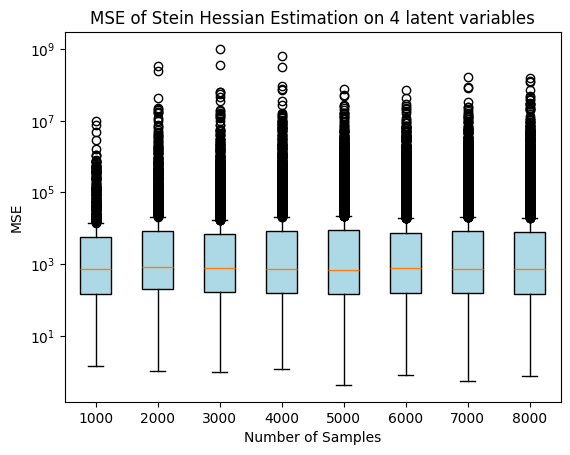

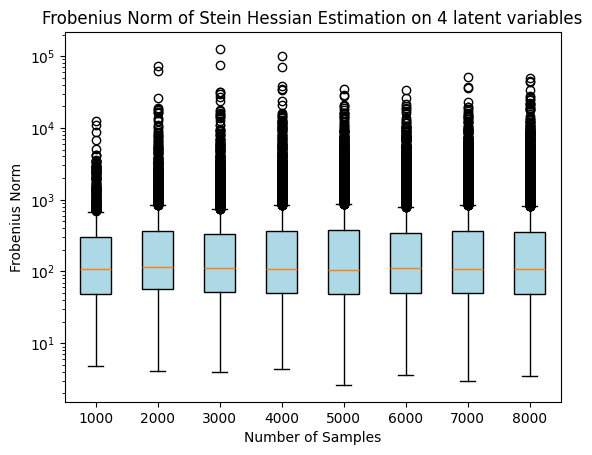

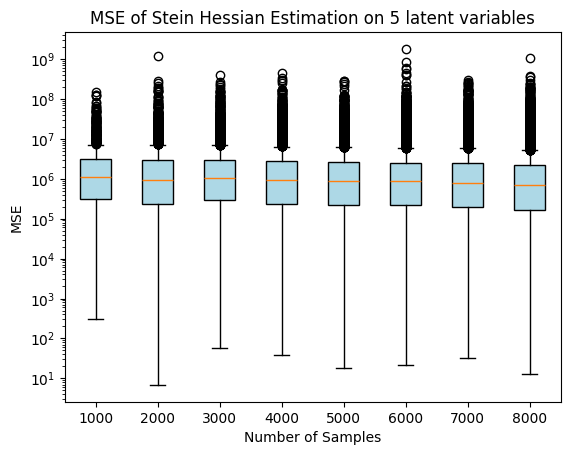

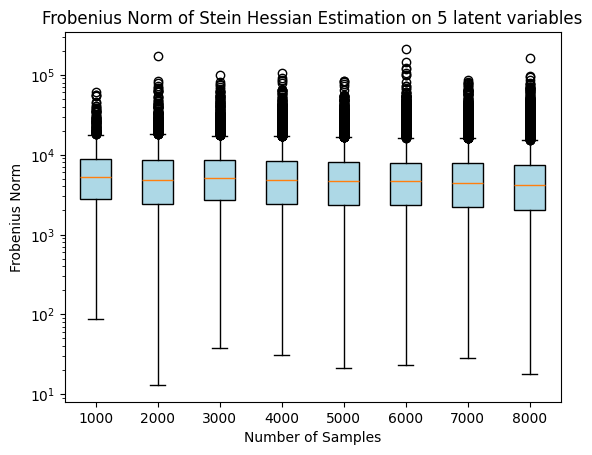

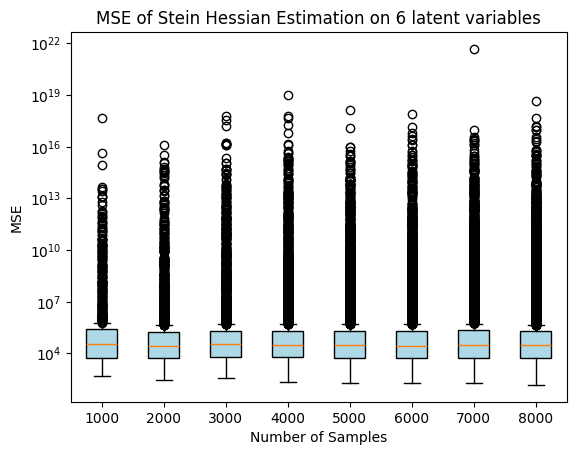

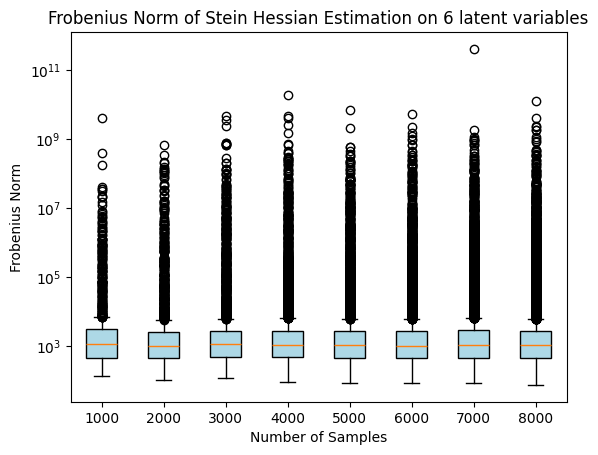

In [77]:
num_samples_vals = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
num_latent_vals = [4,5,6]

for num_latent in num_latent_vals:
    for metric in ['MSE', 'Frobenius Norm']:
        ns_1000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_1000.csv')[metric].to_numpy()
        ns_2000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_2000.csv')[metric].to_numpy()
        ns_3000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_3000.csv')[metric].to_numpy()
        ns_4000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_4000.csv')[metric].to_numpy()
        ns_5000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_5000.csv')[metric].to_numpy()
        ns_6000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_6000.csv')[metric].to_numpy()
        ns_7000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_7000.csv')[metric].to_numpy()
        ns_8000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_8000.csv')[metric].to_numpy()

        data = [ns_1000, ns_2000, ns_3000, ns_4000, ns_5000, ns_6000, ns_7000, ns_8000]
        means = [np.mean(d) for d in data]

        fig, ax = plt.subplots()

        # Create the boxplot
        bp = ax.boxplot(data, patch_artist=True, boxprops=dict(facecolor='lightblue'))
        ax.set_yscale('log')

        # for i, mean in enumerate(means, start=1):
        #     ax.text(i, mean, f'Mean: {mean:.2f}', ha='center', va='bottom', color='red')

        # for i, mean in enumerate(means, start=1):
        #     # Position text above the upper cap (top non-outlier max)
        #     cap_top = bp['caps'][2*(i-1)+1].get_ydata()[0]  # Get y data of the upper cap
        #     ax.text(i, cap_top, f'Mean: {mean:.2f}', ha='center', va='bottom', color='red', fontsize=9, backgroundcolor='white')

        # Setting labels for each boxplot
        ax.set_xticklabels(num_samples_vals)

        # Adding a title and labels
        ax.set_title(f'{metric} of Stein Hessian Estimation on {num_latent} latent variables')
        ax.set_ylabel(f'{metric}')
        ax.set_xlabel('Number of Samples')
        # ax.set_ylim(0, 500)

        # Show the plot
        plt.show()

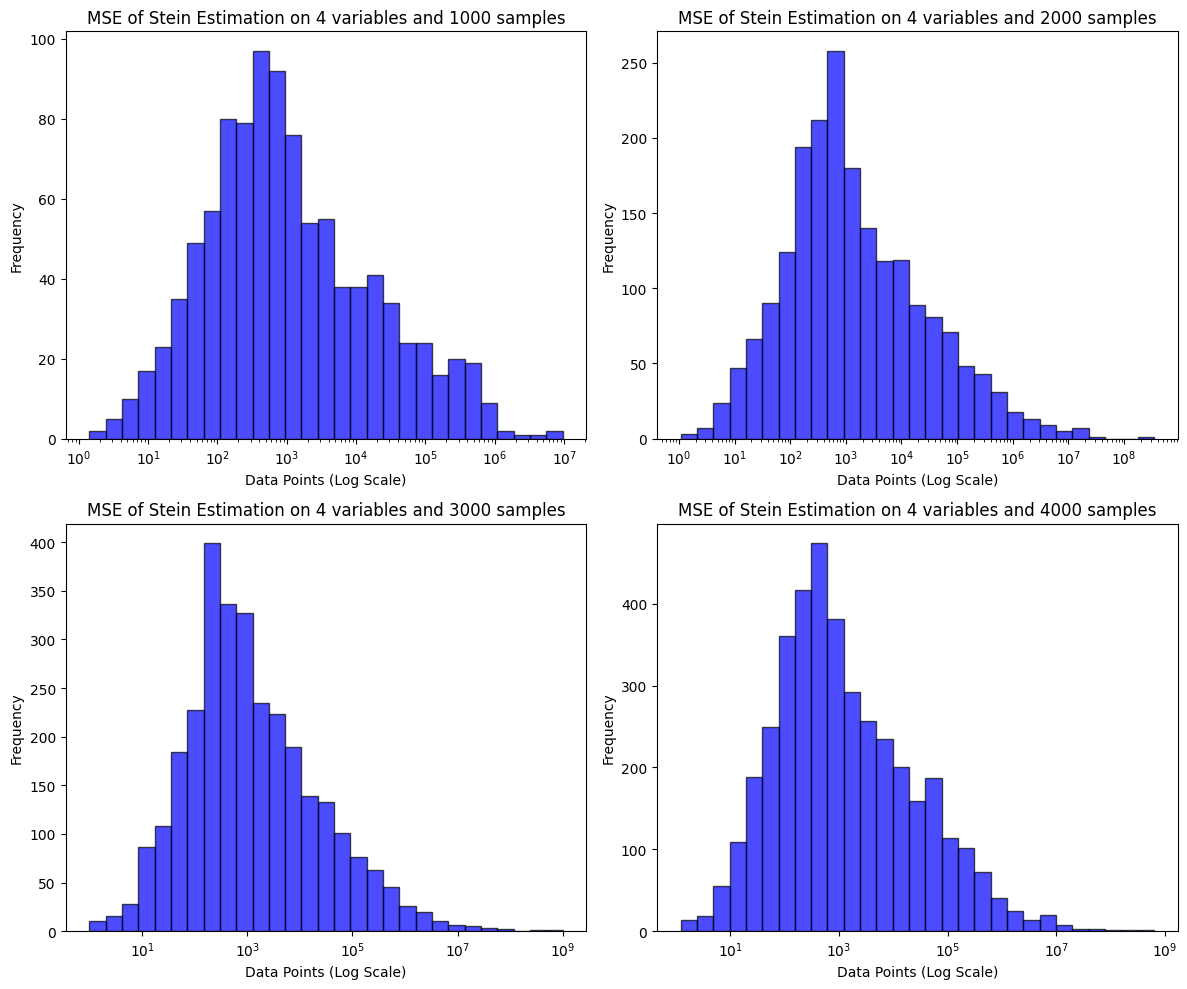

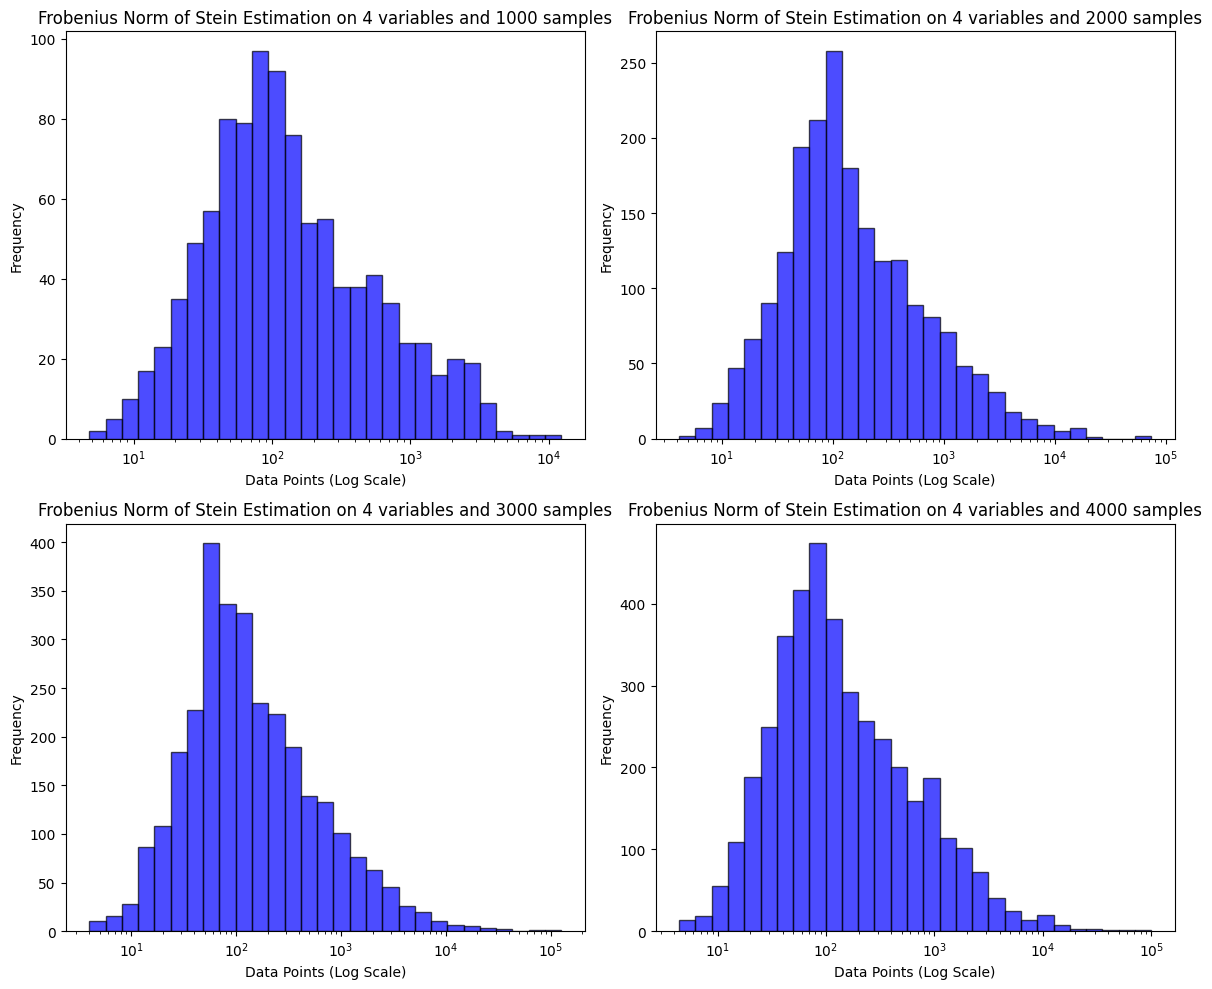

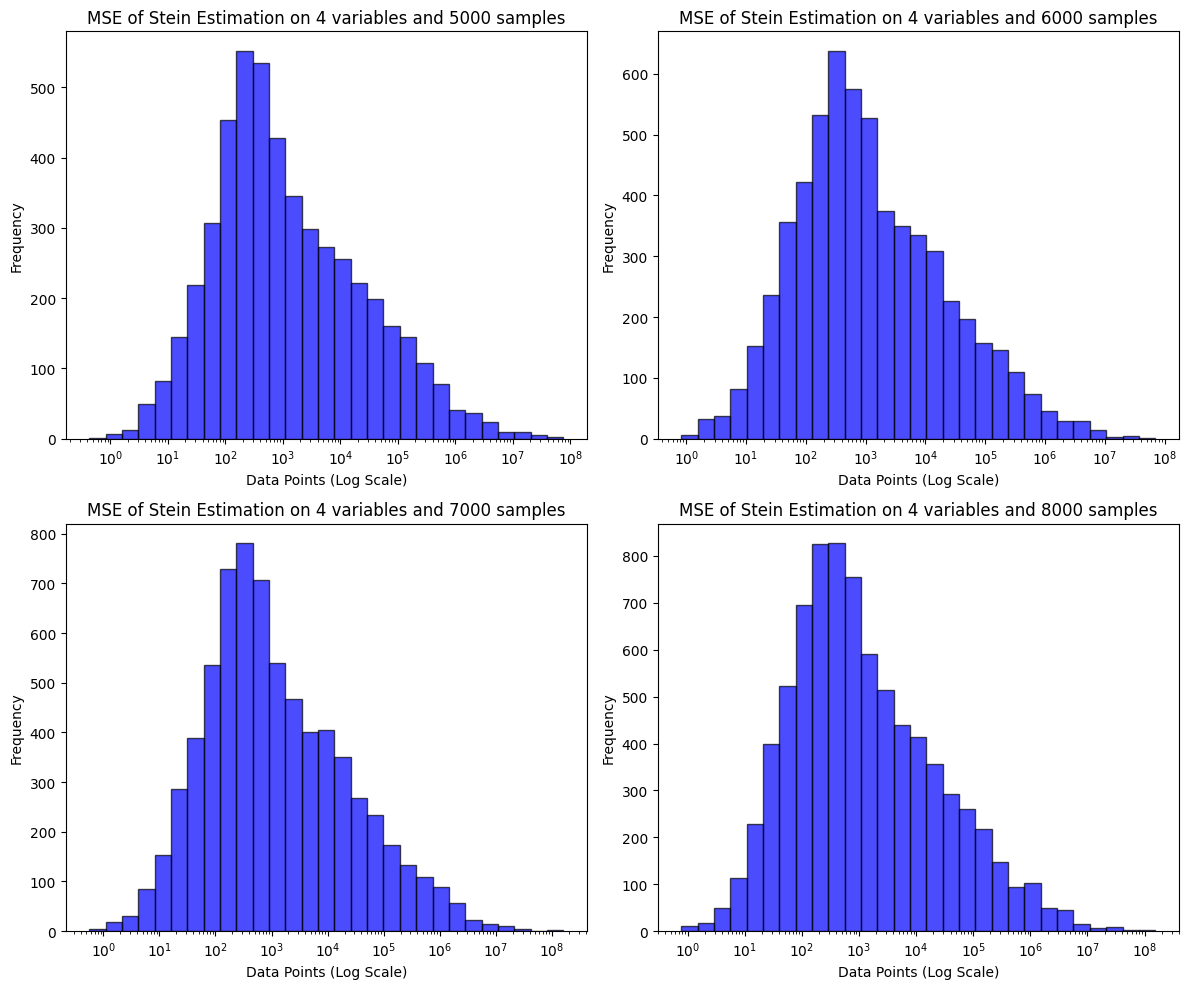

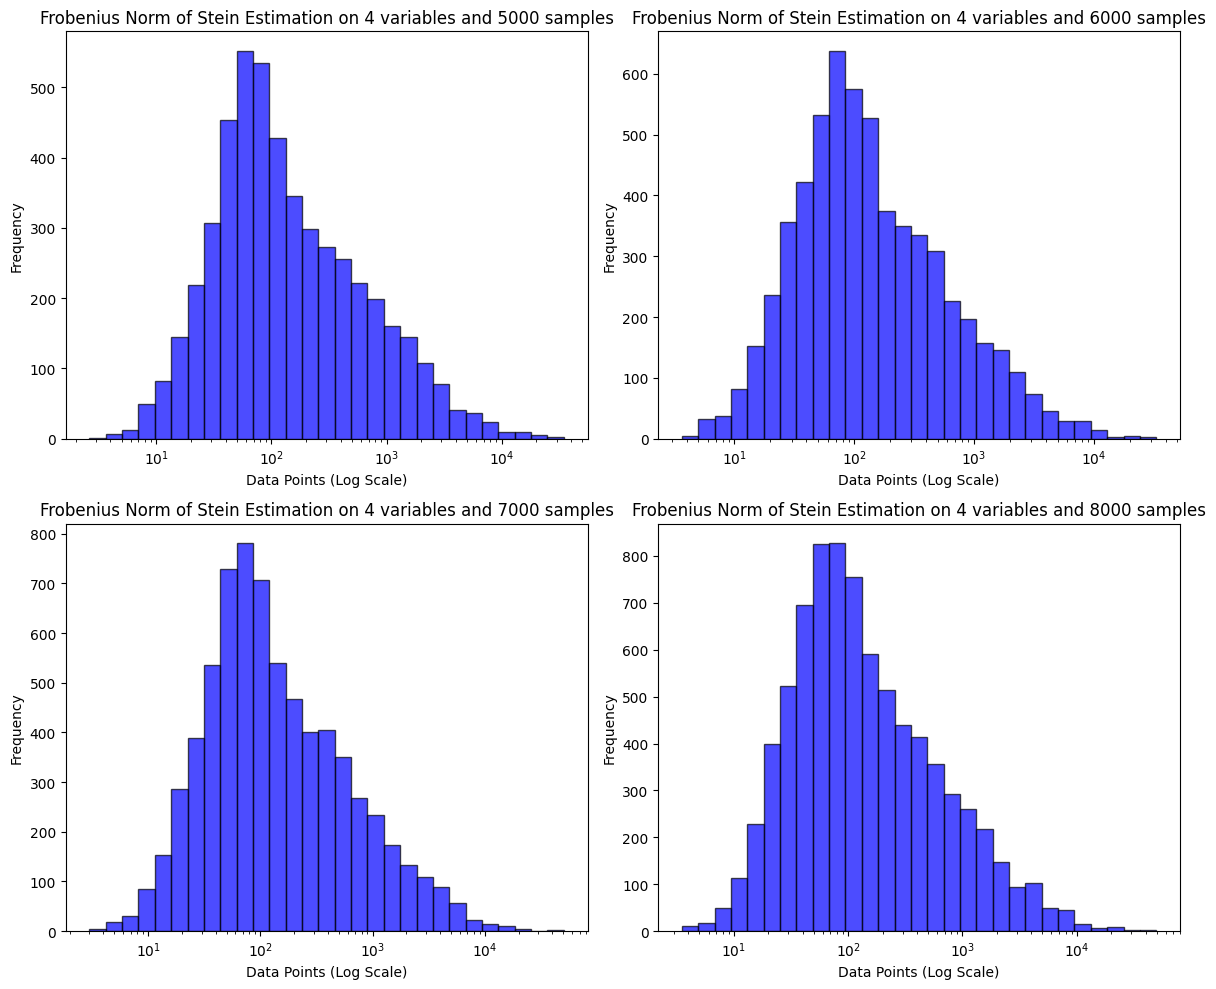

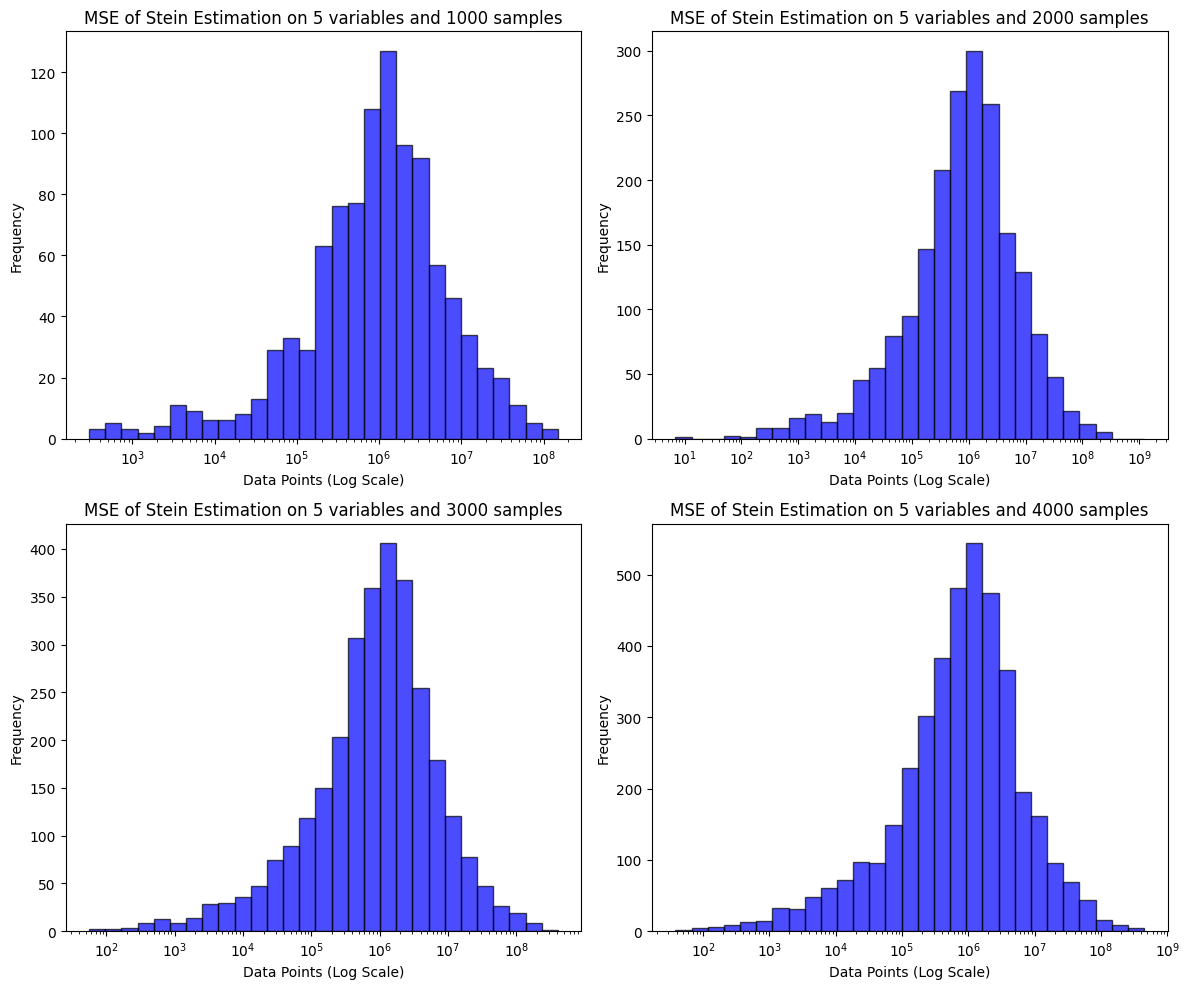

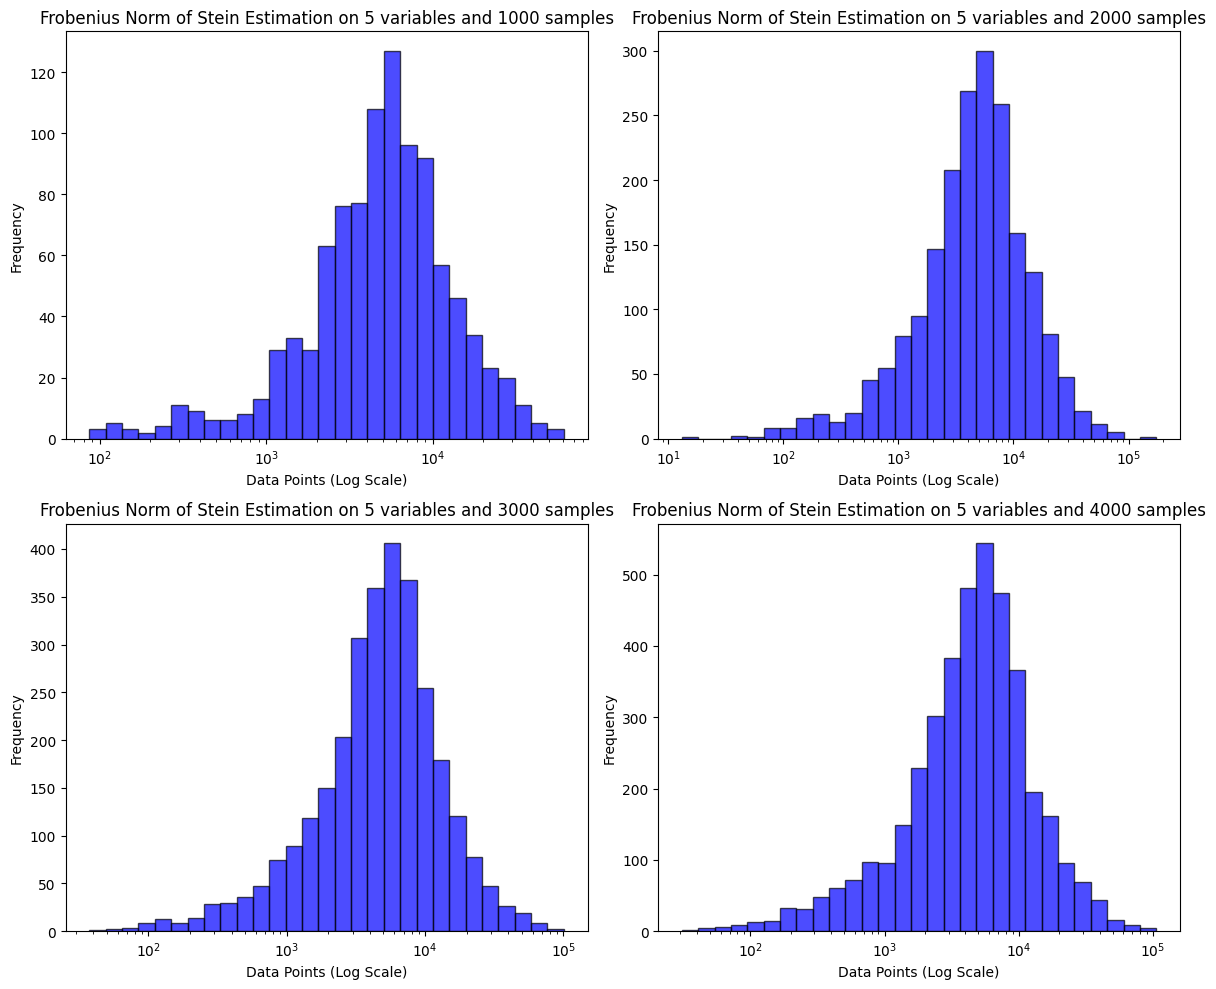

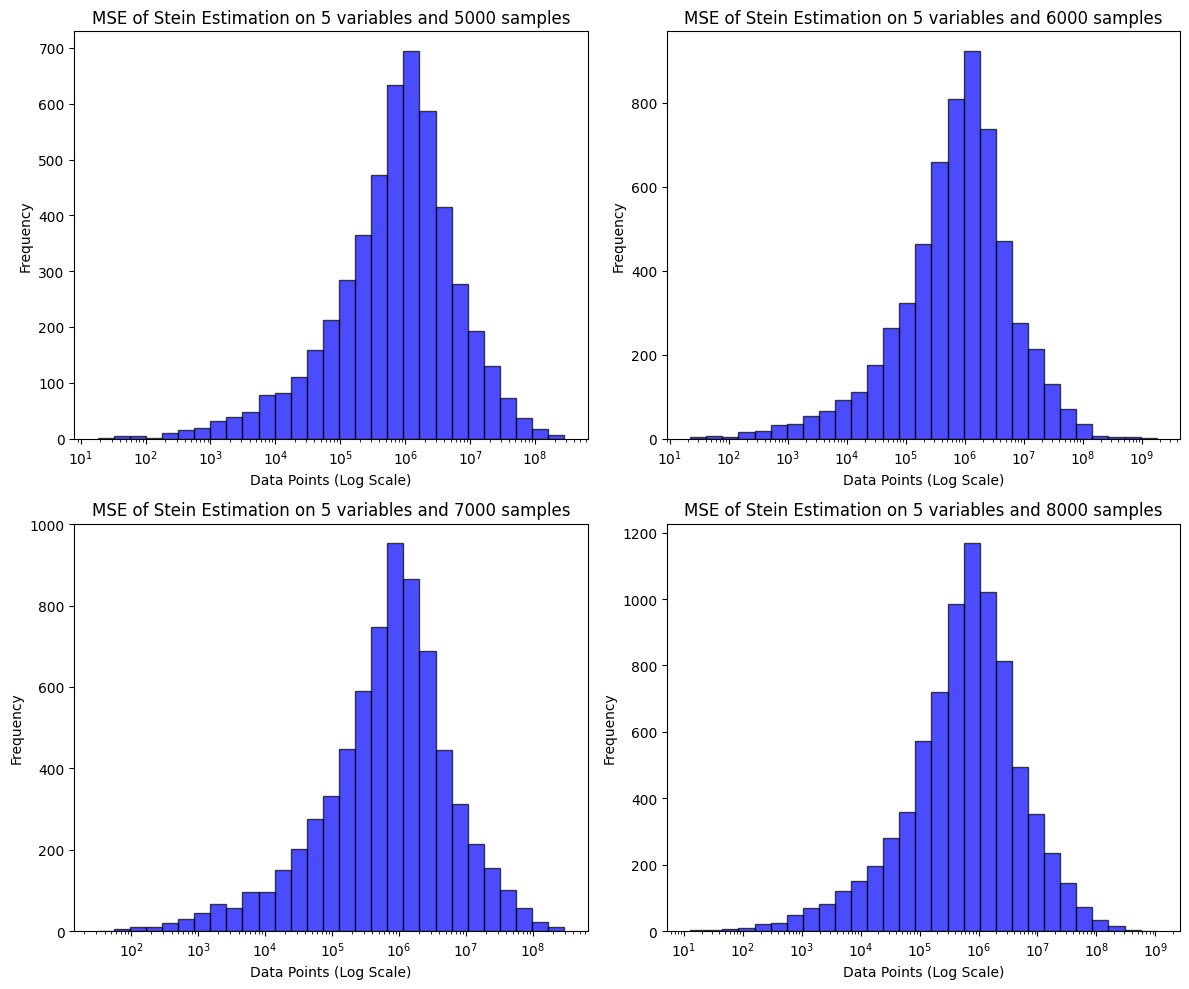

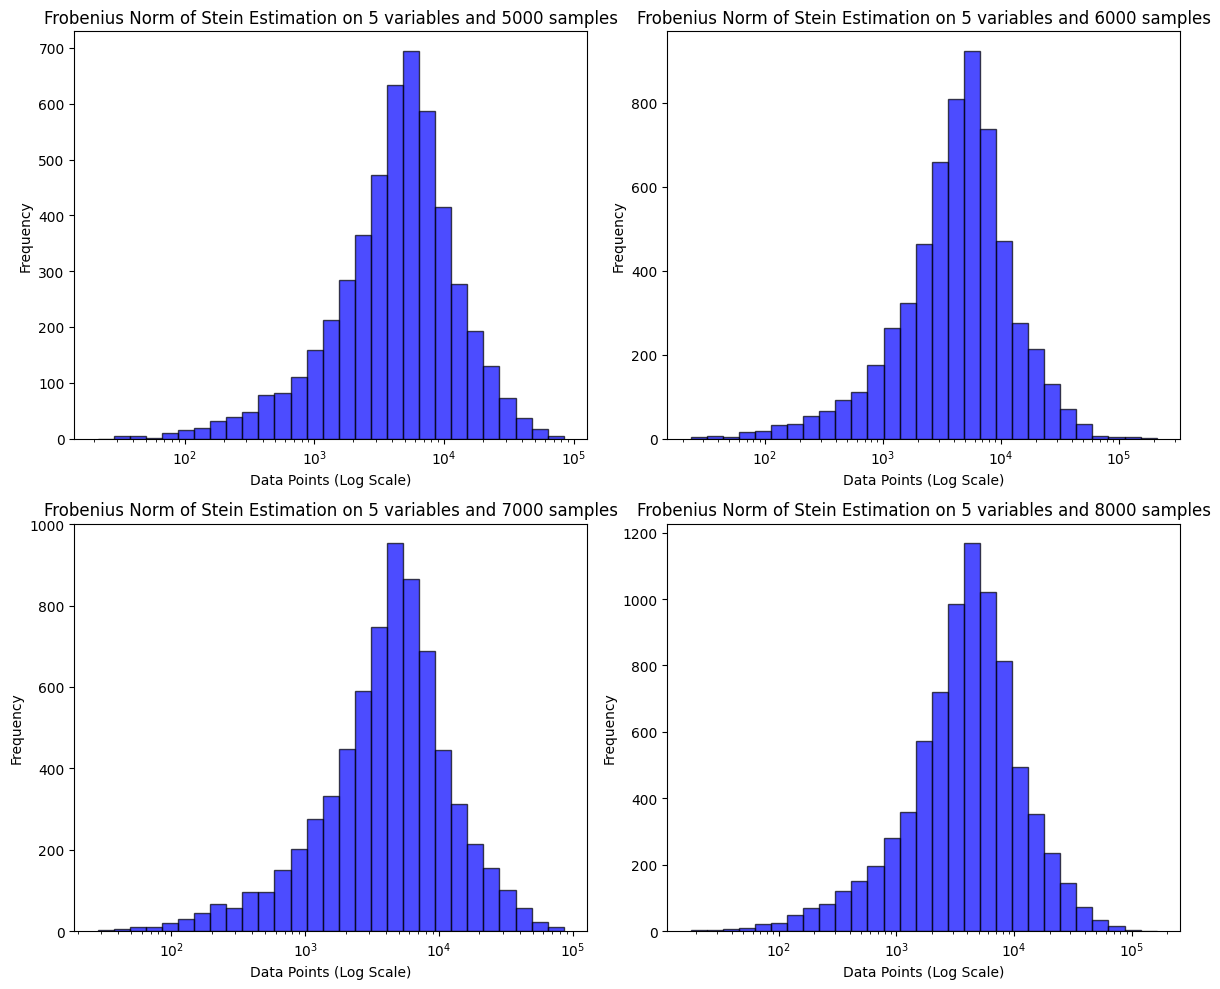

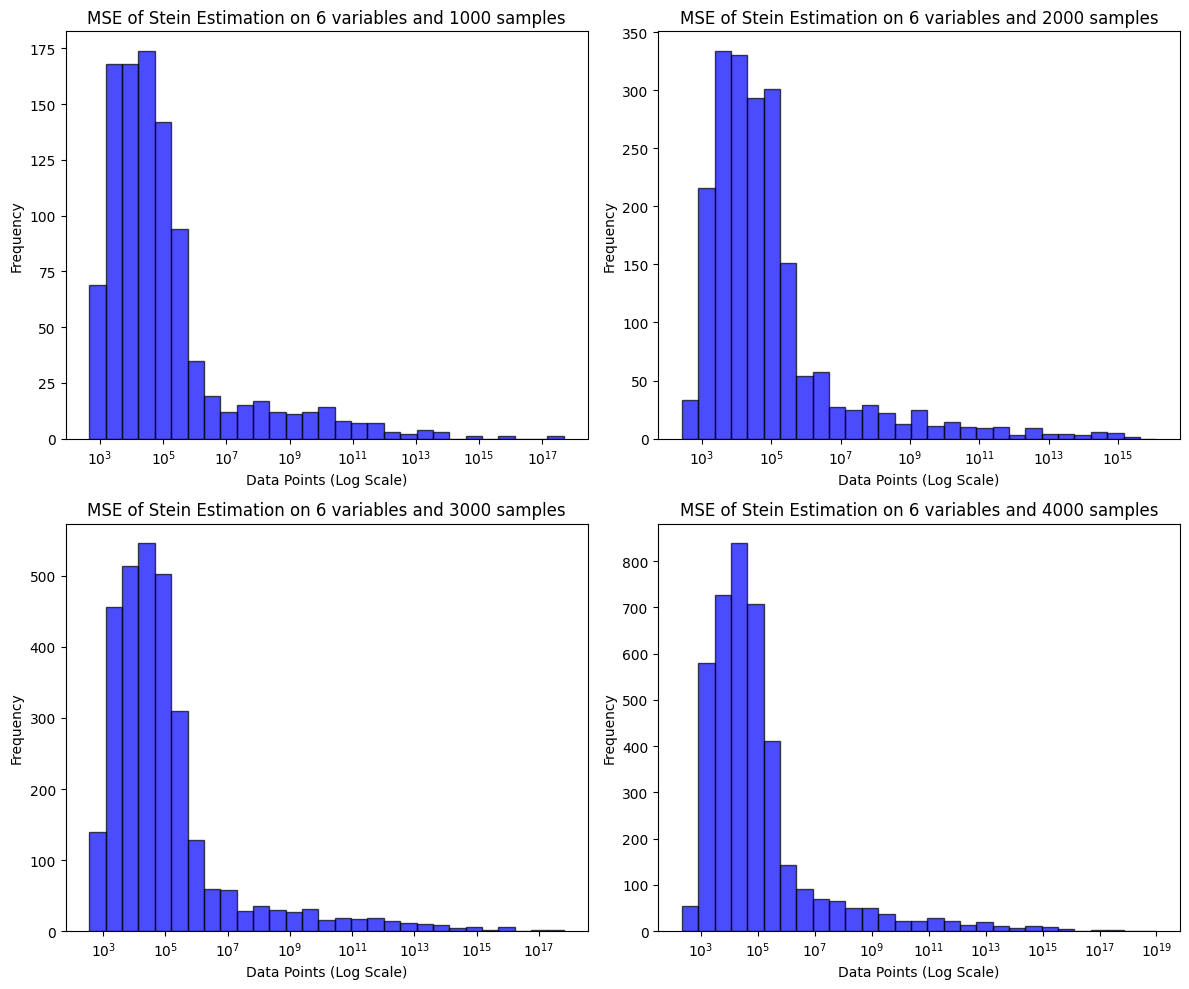

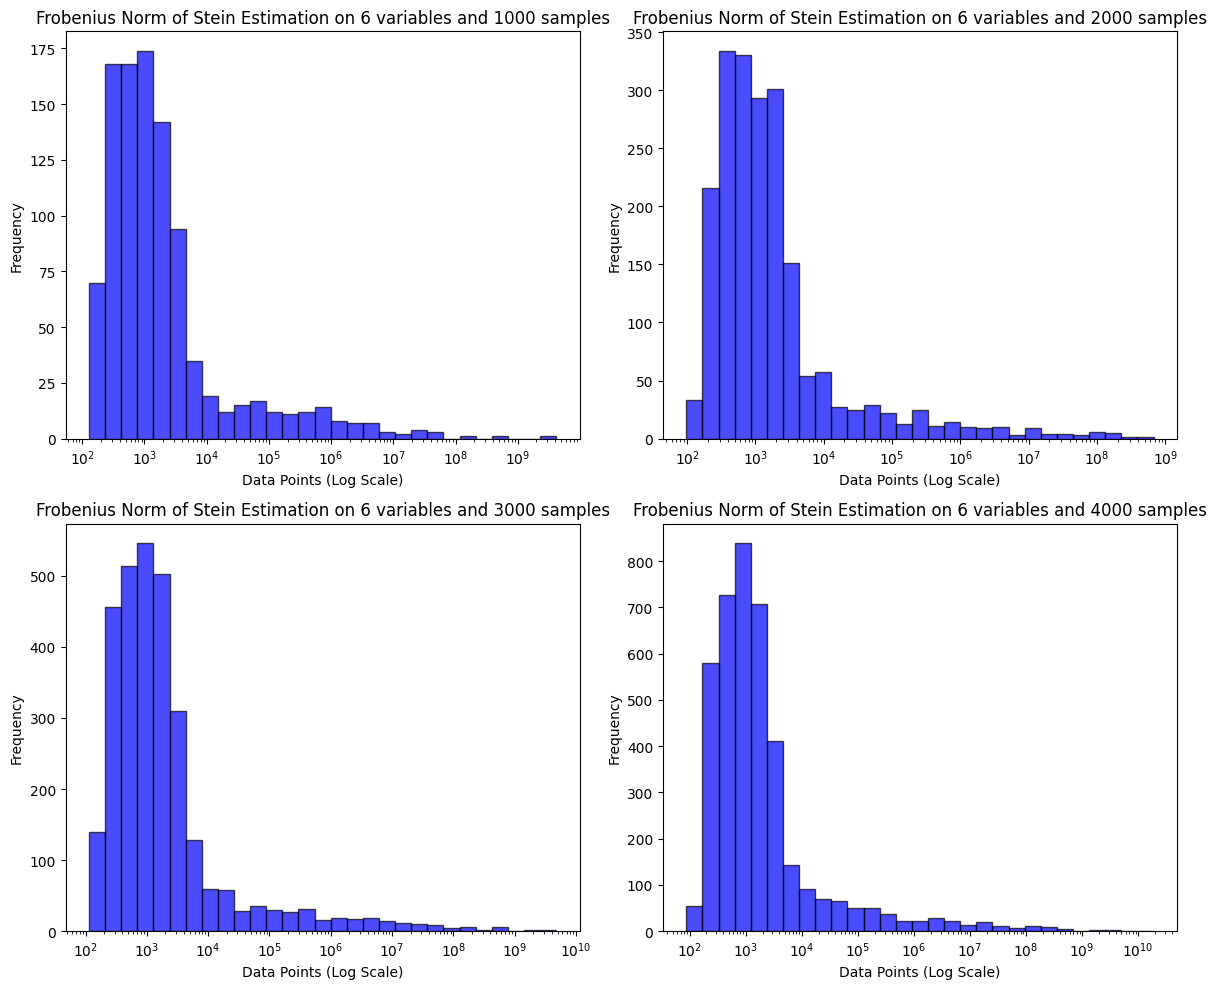

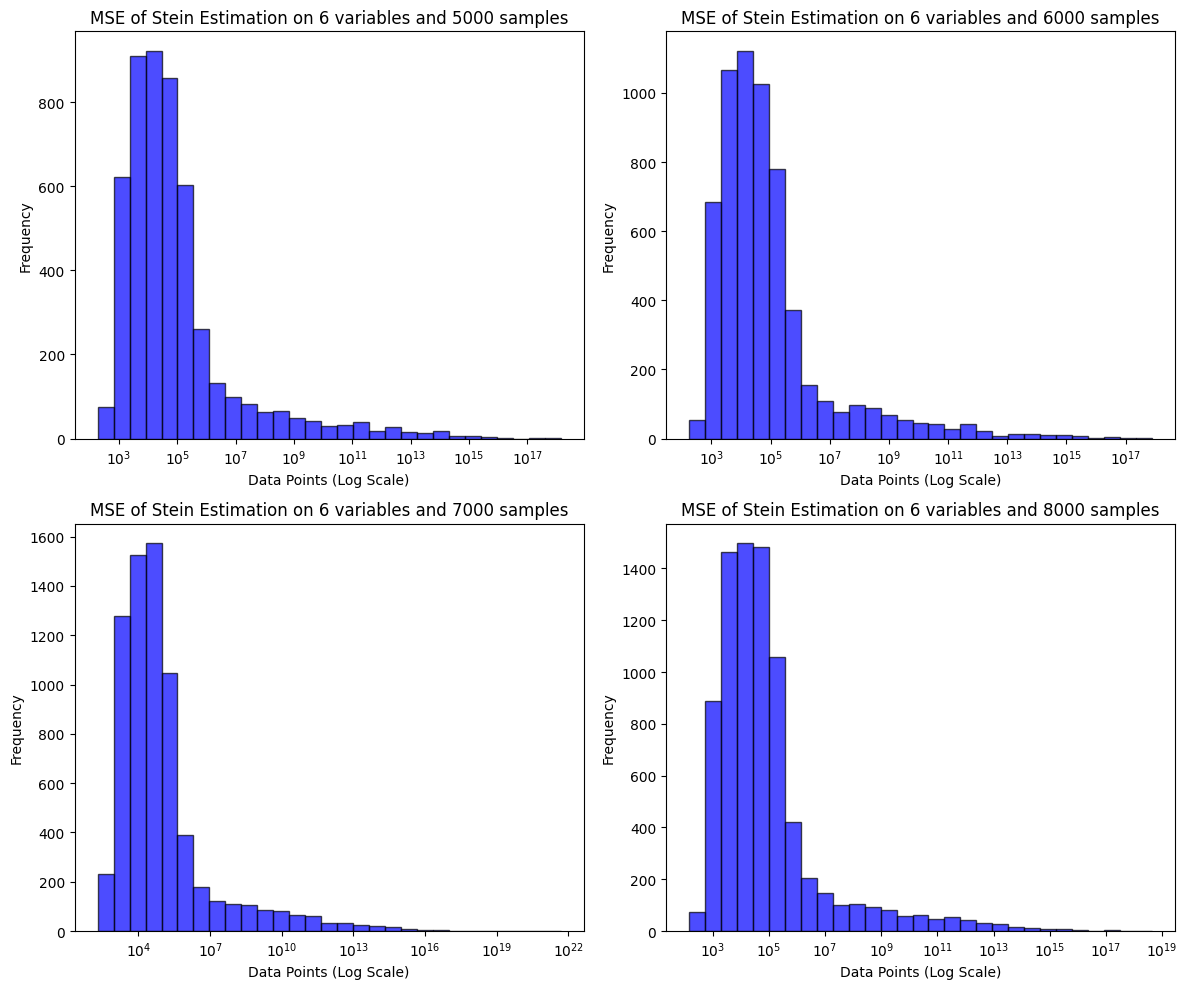

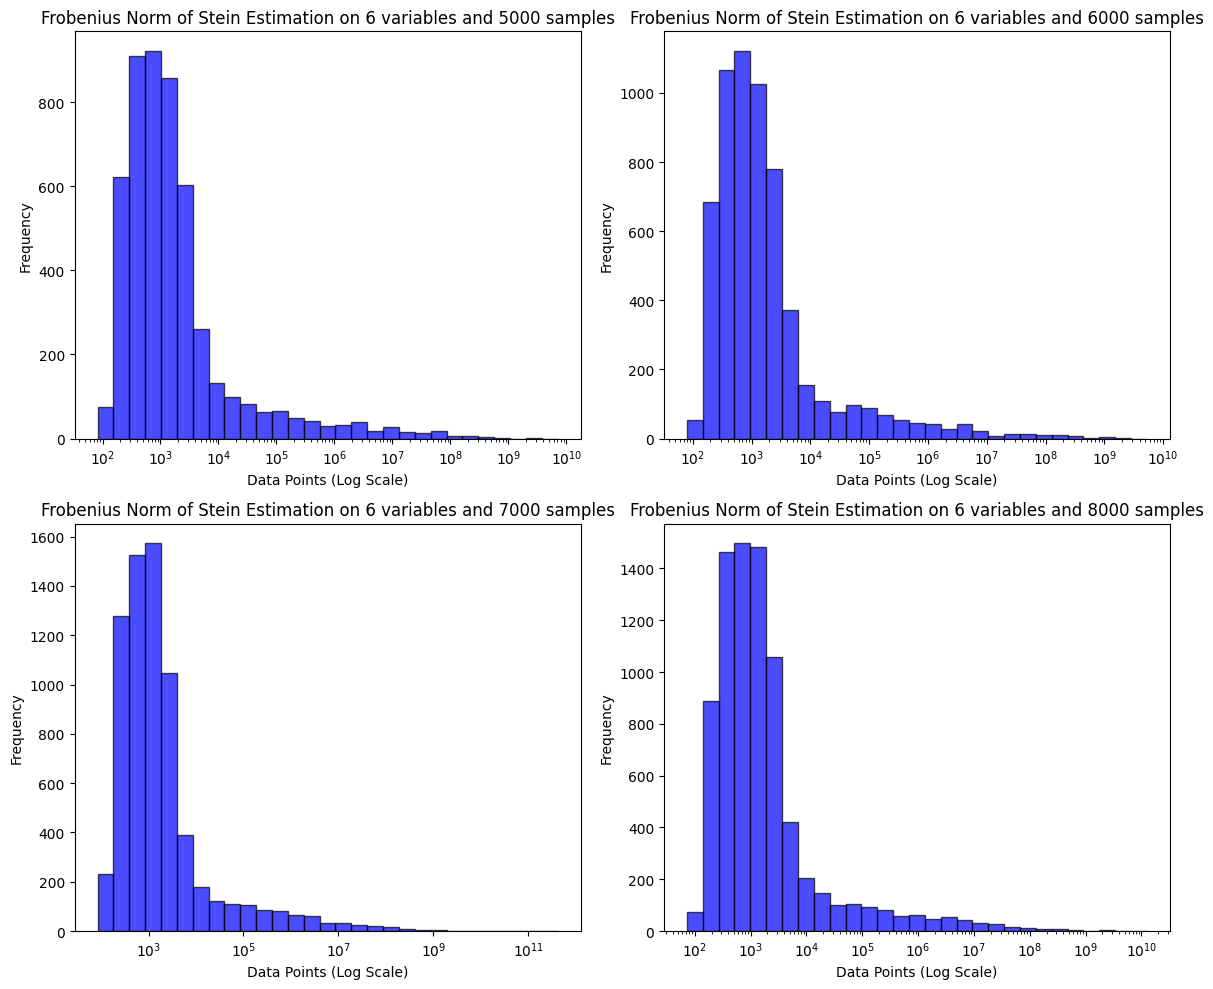

In [94]:
# num_sampels =4
# metric = 'MSE'
# num_samples_vals = [1000, 2000, 3000,4000]

# ns_1000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_1000.csv')[metric].to_numpy()
# ns_2000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_2000.csv')[metric].to_numpy()
# ns_3000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_3000.csv')[metric].to_numpy()
# ns_4000 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_4000.csv')[metric].to_numpy()

# data = [ns_1000, ns_2000, ns_3000, ns_4000]
# means = [np.mean(d) for d in data]

# fig, ax = plt.subplots()

# # Create the boxplot
# boxprops = ax.boxplot(data, patch_artist=True, boxprops=dict(facecolor='lightblue'))
# ax.set_yscale('log')

# for i, mean in enumerate(means, start=1):
#     ax.text(i, mean, f'Mean: {mean:.2f}', ha='center', va='bottom', color='red')

# # Setting labels for each boxplot
# ax.set_xticklabels(num_samples_vals)

# # Adding a title and labels
# ax.set_title(f'{metric} of Stein Hessian Estimation on {num_latent} latent variables')
# ax.set_ylabel(f'{metric}')
# ax.set_xlabel('Number of Samples')
# # ax.set_ylim(0, 500)

# # Show the plot
# plt.show()

for num_latent in num_latent_vals:
    for num_samples_l in [[1000,2000,3000,4000], [5000,6000,7000,8000]]:
        for metric in ['MSE', 'Frobenius Norm']:
            data1 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_{num_samples_l[0]}.csv')[metric].to_numpy()
            data2 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_{num_samples_l[1]}.csv')[metric].to_numpy()
            data3 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_{num_samples_l[2]}.csv')[metric].to_numpy()
            data4 = pd.read_csv(f'tests/stein/nl_{num_latent}_ns_{num_samples_l[3]}.csv')[metric].to_numpy()

            datasets = [data1, data2, data3, data4]

            titles = [f'{metric} of Stein Estimation on {num_latent} variables and {num_samples_l[i]} samples' for i in range(4)]

            fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

            axes = axes.flatten()

            # Loop through all datasets and their corresponding axes
            for ax, data, title in zip(axes, datasets, titles):
                # Calculate bins
                bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), num=30)
                
                # Plot histogram
                ax.hist(data, bins=bins, color='blue', alpha=0.7, edgecolor='black')
                ax.set_xscale('log')  # Set the x-axis to logarithmic scale
                
                # Set titles and labels
                ax.set_title(title)
                ax.set_xlabel('Data Points (Log Scale)')
                ax.set_ylabel('Frequency')

            # Adjust layout to prevent overlap
            plt.tight_layout()

            # Show the plot
            plt.show()


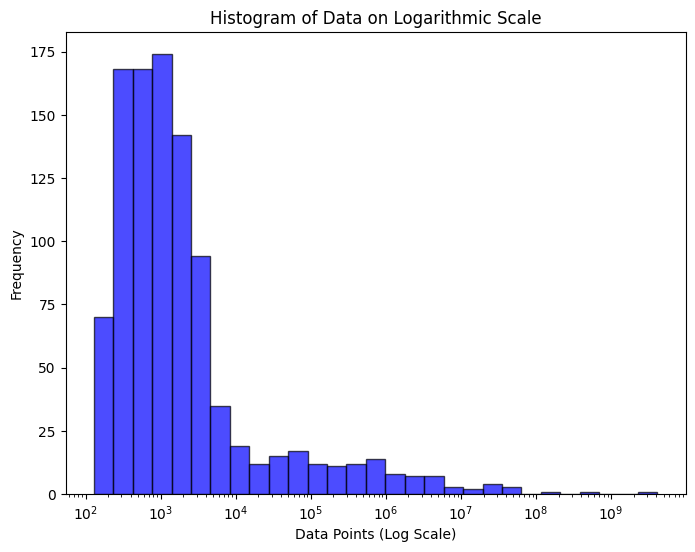

In [93]:
# Create the histogram
bin_edges = np.logspace(np.log10(np.min(ns_1000)), np.log10(np.max(ns_1000)), num=30)

plt.figure(figsize=(8, 6))
plt.hist(ns_1000, bins=bin_edges, color='blue', alpha=0.7, edgecolor='black')
plt.xscale('log')  # Set the x-axis to logarithmic scale

# Add titles and labels
plt.title('Histogram of Data on Logarithmic Scale')
plt.xlabel('Data Points (Log Scale)')
plt.ylabel('Frequency')

# Show the plot
plt.show()

# Sliced Score Matching

In [36]:
graph = SyntheticDAG(num_latent, DAG_type)

In [45]:
U,X,noises = graph.sample_scaled(G, num_samples+50000)
U_tr = U[num_samples:]
X_tr = X[num_samples:]
U = U[:num_samples]
X = X[:num_samples]

In [50]:
HU = H_U(graph, U)

In [55]:
HU_ssm = ssm_hess(U, U_tr)

In [59]:
torch.var(HU, dim=0)

tensor([[5.7589e+00, 4.5447e+00, 4.7008e-11, 3.7465e-11],
        [4.5447e+00, 1.1772e+01, 1.0235e+01, 2.7165e-11],
        [6.0190e-11, 1.0235e+01, 7.5231e+00, 7.2120e+00],
        [3.2324e-11, 2.4827e-11, 7.2120e+00, 1.6908e-10]],
       grad_fn=<VarBackward0>)

In [58]:
torch.var(HU_ssm, dim=0)

tensor([[49.4839, 22.6729, 18.3475, 14.2045],
        [25.3877, 45.8132, 28.8706, 19.7767],
        [21.7905, 30.1321, 51.9595, 25.7556],
        [16.4815, 22.2709, 27.5991, 28.9739]], grad_fn=<VarBackward0>)

In [61]:
HU_ssm

tensor([[[-100.8515,   10.8533,   -1.0562,    1.6494],
         [  10.0152,  -79.1677,   18.1358,   -0.2279],
         [  -0.9171,   17.1106,  -83.1610,   19.3560],
         [   0.9602,    0.2305,   19.8864,  -85.4122]],

        [[-100.5828,   11.2175,   -1.0823,    0.1143],
         [  12.0132,  -86.7564,   11.1317,   -1.4002],
         [  -0.8123,   11.5298,  -83.0527,    6.8153],
         [   0.1095,   -0.7453,    7.1760,  -85.0390]],

        [[-101.2402,    9.3396,   -1.6512,    2.0861],
         [  10.3748,  -90.5147,   20.1721,    1.3754],
         [  -1.4489,   21.0099,  -84.0634,   13.8145],
         [   2.3543,    1.3456,   14.2630,  -86.7640]],

        ...,

        [[ -85.5591,    7.6019,   -7.9330,   11.4913],
         [   7.3079,  -71.2176,   19.5852,    2.5456],
         [ -10.3733,   20.8702,  -65.0150,   -0.9645],
         [  10.4487,    5.8065,    0.3424,  -68.7076]],

        [[ -81.7848,   -1.5418,    1.3882,    4.7249],
         [  -2.4966,  -72.3386,   14.7524, 

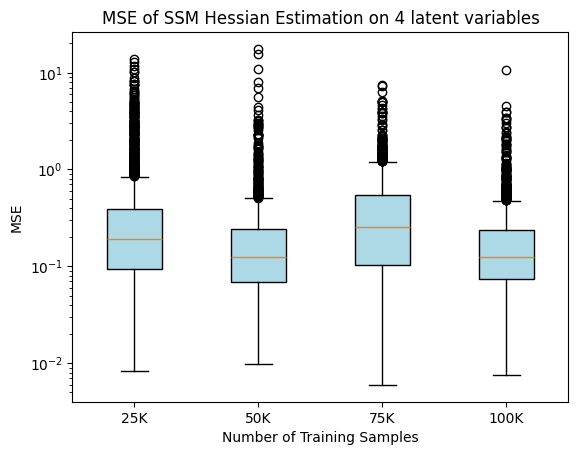

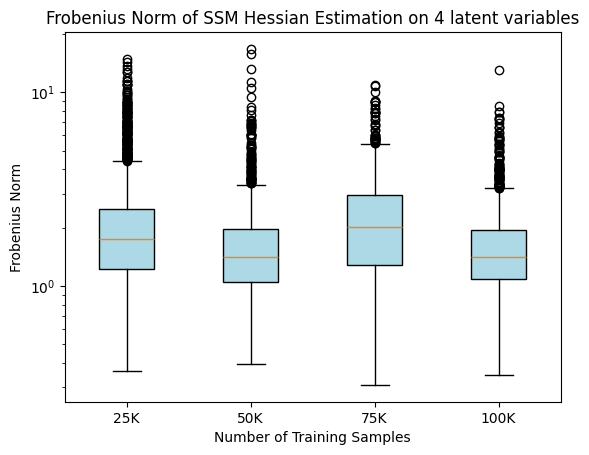

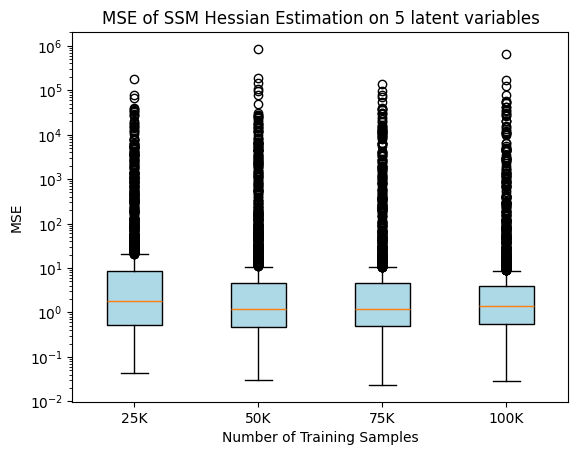

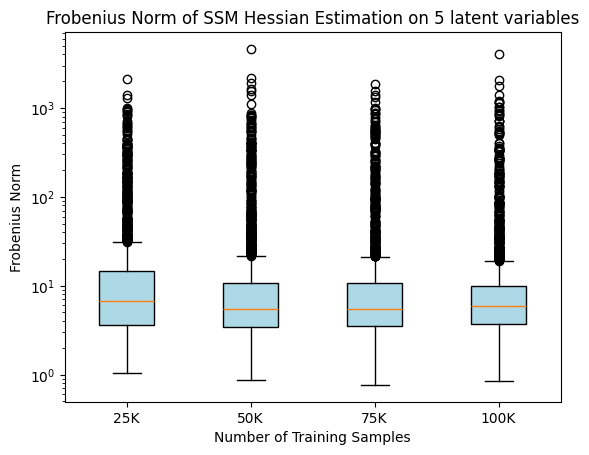

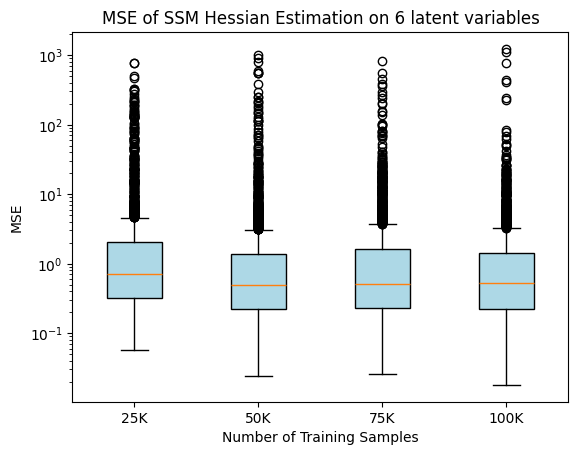

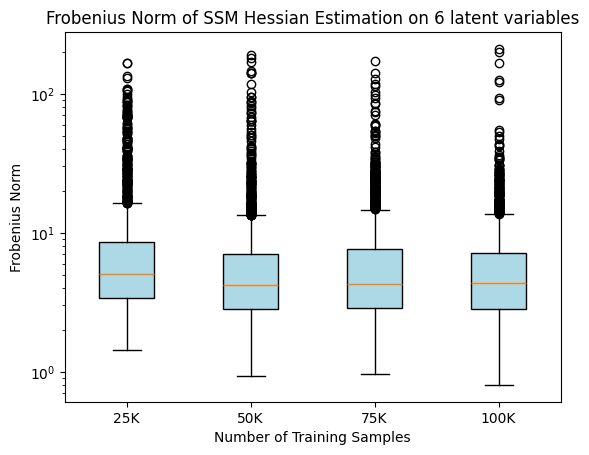

In [111]:
num_training_examples = [25000, 50000, 75000, 100000]
num_testing = 2000
num_latent_vals = [4,5,6]

for num_latent in num_latent_vals:
    for metric in ['MSE', 'Frobenius Norm']:
        ns_25 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_250.0K.csv')[metric].to_numpy()
        ns_50 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_500.0K.csv')[metric].to_numpy()
        ns_75 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_750.0K.csv')[metric].to_numpy()
        ns_100 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_1000.0K.csv')[metric].to_numpy()

        data = [ns_25, ns_50, ns_75, ns_100]
        means = [np.mean(d) for d in data]

        fig, ax = plt.subplots()

        # Create the boxplot
        bp = ax.boxplot(data, patch_artist=True, boxprops=dict(facecolor='lightblue'))
        ax.set_yscale('log')

        # for i, mean in enumerate(means, start=1):
        #     ax.text(i, mean, f'Mean: {mean:.2f}', ha='center', va='bottom', color='red')

        # for i, mean in enumerate(means, start=1):
        #     # Position text above the upper cap (top non-outlier max)
        #     cap_top = bp['caps'][2*(i-1)+1].get_ydata()[0]  # Get y data of the upper cap
        #     ax.text(i, cap_top, f'Mean: {mean:.2f}', ha='center', va='bottom', color='red', fontsize=9, backgroundcolor='white')

        # Setting labels for each boxplot
        ax.set_xticklabels([f'{int(num_training_examples[i]/1000)}K' for i in range(4)])

        # Adding a title and labels
        ax.set_title(f'{metric} of SSM Hessian Estimation on {num_latent} latent variables')
        ax.set_ylabel(f'{metric}')
        ax.set_xlabel('Number of Training Samples')
        # ax.set_ylim(0, 500)

        # Show the plot
        plt.show()

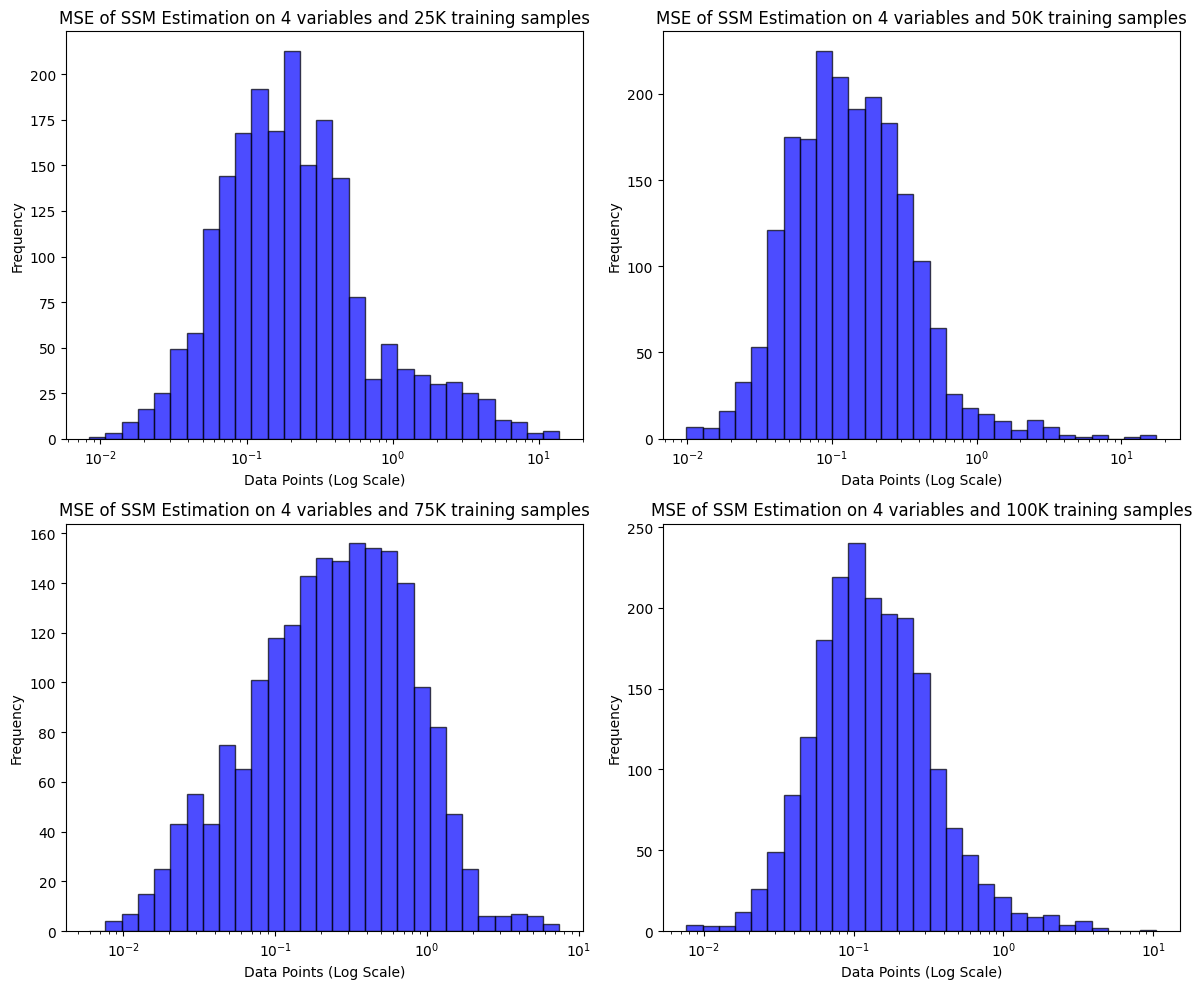

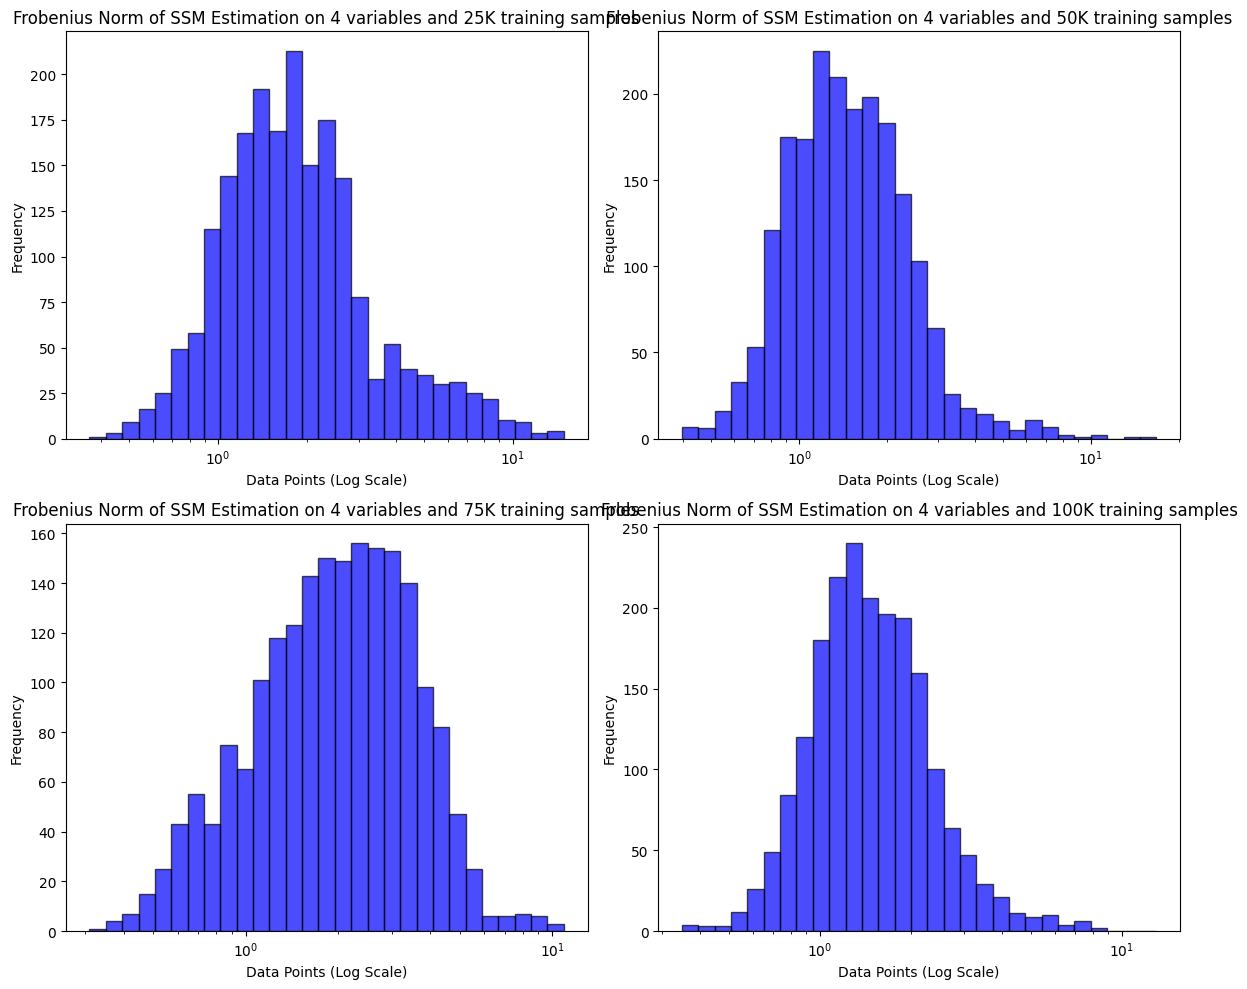

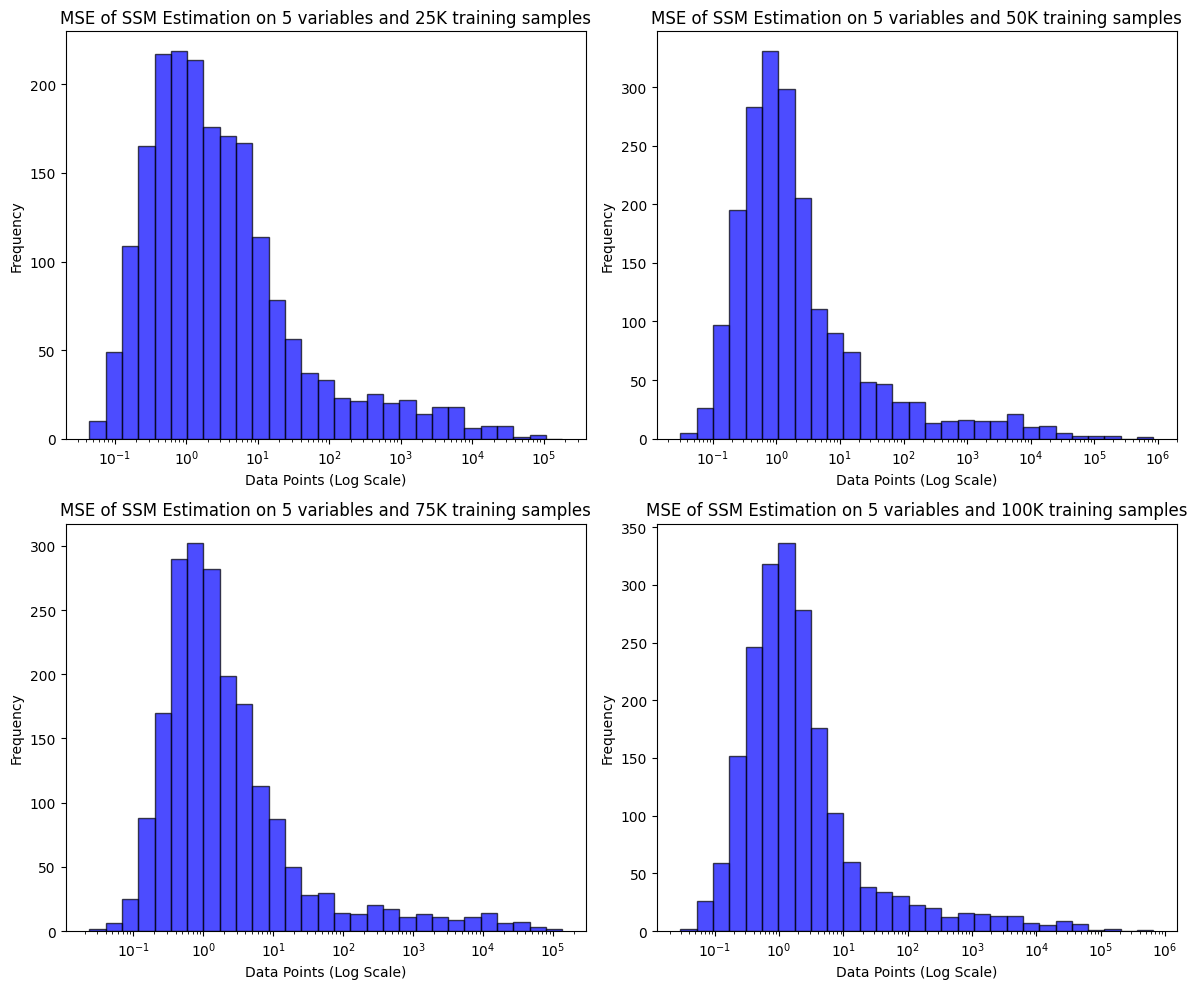

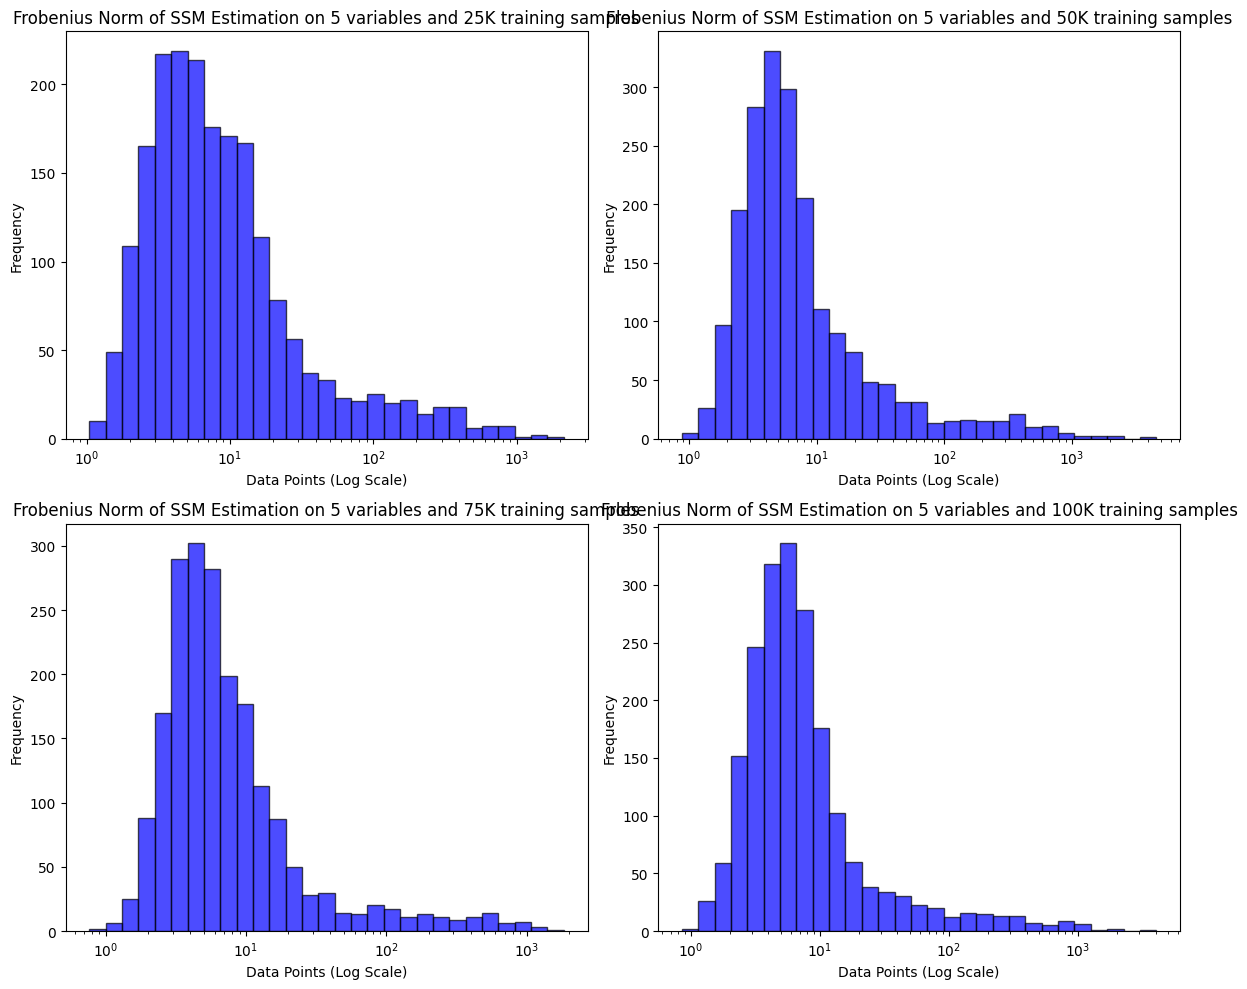

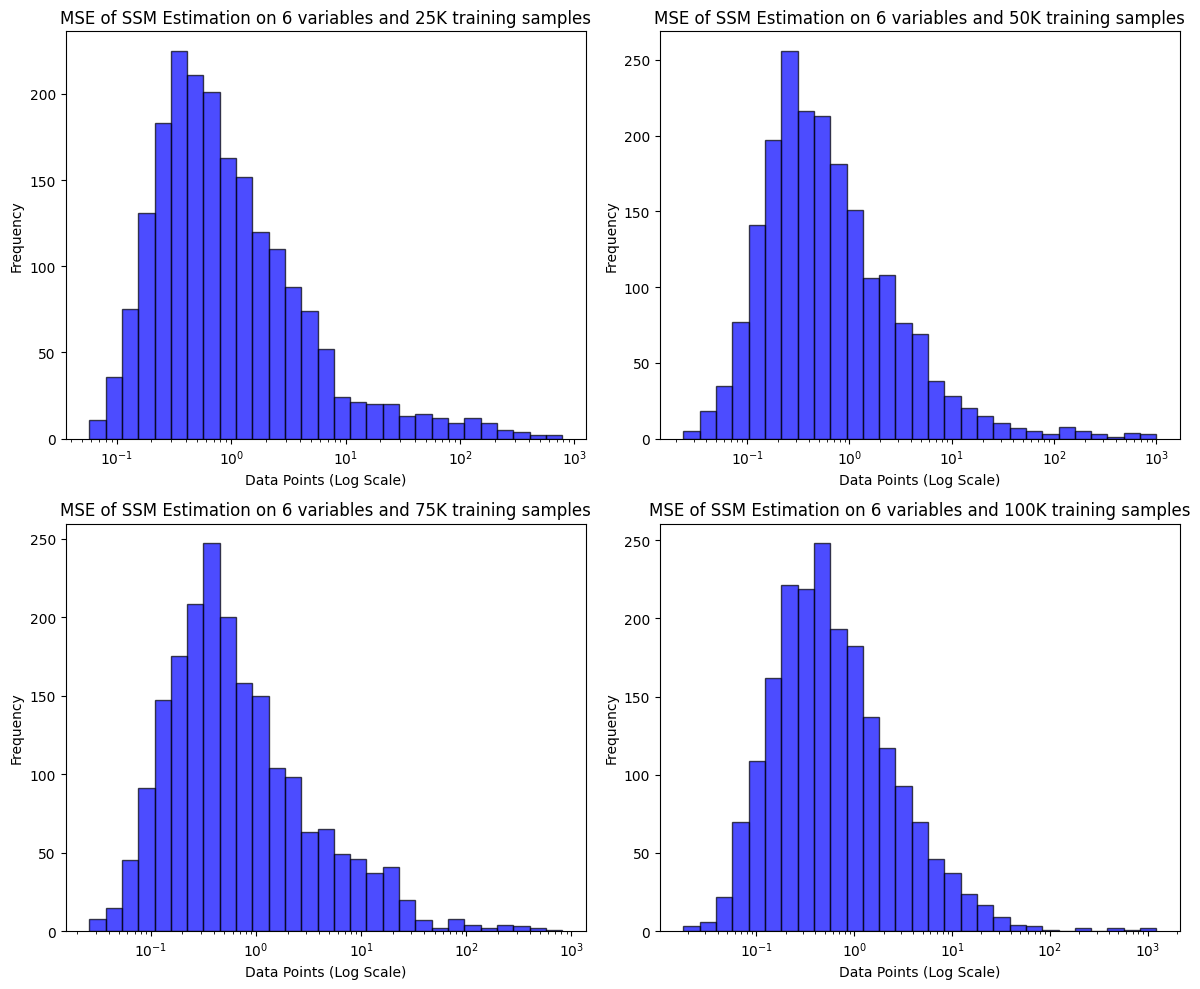

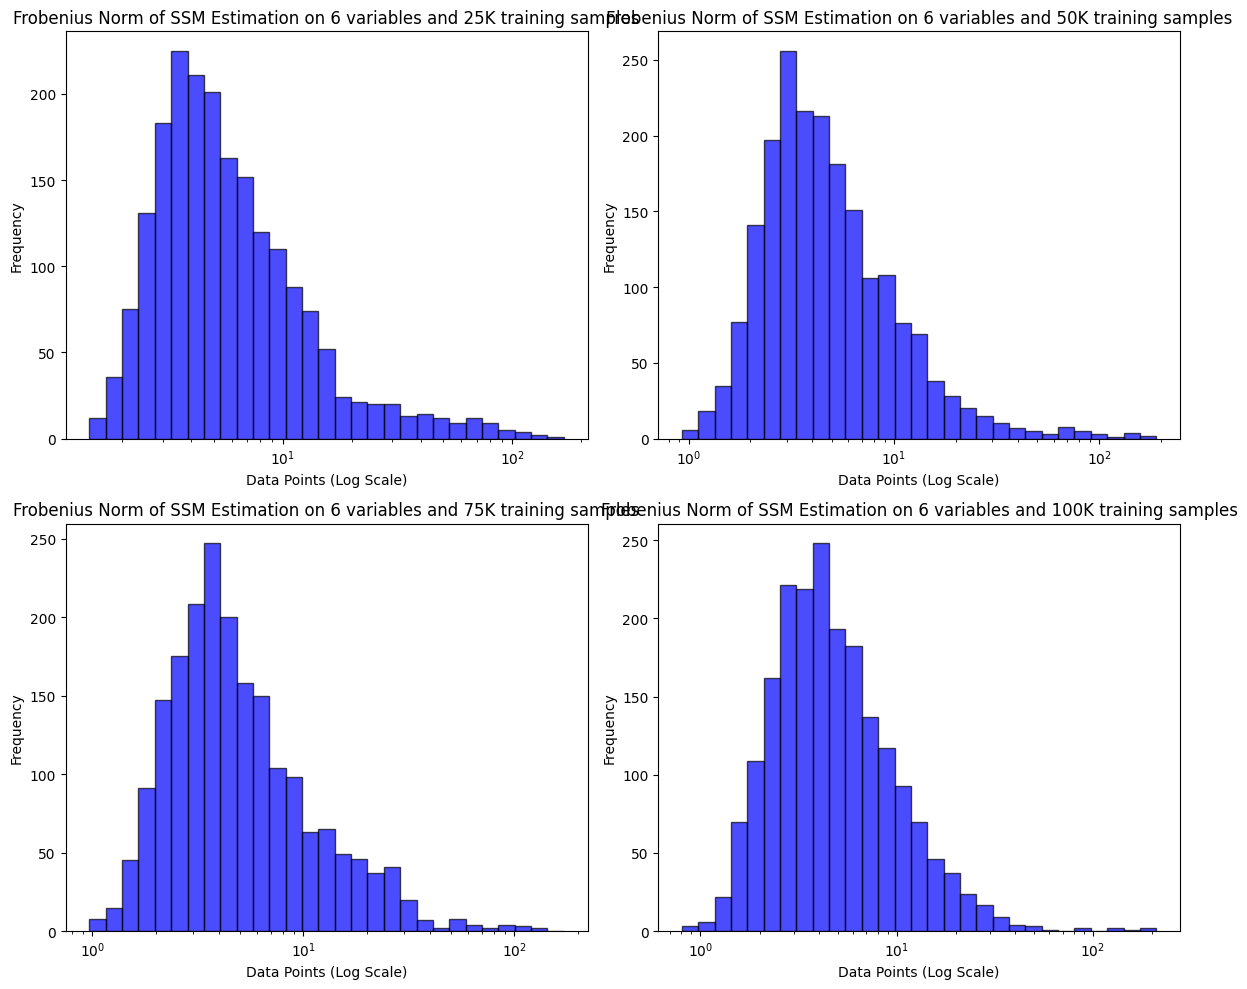

In [112]:
# num_latent = 4
# metric = 'MSE'
# num_training_examples = [25000, 50000, 75000, 100000]

# ns_25 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_250.0K.csv')[metric].to_numpy()
# ns_50 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_500.0K.csv')[metric].to_numpy()
# ns_75 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_750.0K.csv')[metric].to_numpy()
# ns_100 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_1000.0K.csv')[metric].to_numpy()

# data = [ns_25, ns_50, ns_75, ns_100]
# means = [np.mean(d) for d in data]

# fig, ax = plt.subplots()

# # Create the boxplot
# bp = ax.boxplot(data, patch_artist=True, boxprops=dict(facecolor='lightblue'))
# ax.set_yscale('log')

# # for i, mean in enumerate(means, start=1):
# #     ax.text(i, mean, f'Mean: {mean:.2f}', ha='center', va='bottom', color='red')

# # for i, mean in enumerate(means, start=1):
# #     # Position text above the upper cap (top non-outlier max)
# #     cap_top = bp['caps'][2*(i-1)+1].get_ydata()[0]  # Get y data of the upper cap
# #     ax.text(i, cap_top, f'Mean: {mean:.2f}', ha='center', va='bottom', color='red', fontsize=9, backgroundcolor='white')

# # Setting labels for each boxplot
# ax.set_xticklabels([f'{int(num_training_examples[i]/1000)}K' for i in range(4)])

# # Adding a title and labels
# ax.set_title(f'{metric} of SSM Hessian Estimation on {num_latent} latent variables')
# ax.set_ylabel(f'{metric}')
# ax.set_xlabel('Number of Training Samples')
# # ax.set_ylim(0, 500)

# # Show the plot
# plt.show()

for num_latent in num_latent_vals:
    for metric in ['MSE', 'Frobenius Norm']:
        ns_25 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_250.0K.csv')[metric].to_numpy()
        ns_50 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_500.0K.csv')[metric].to_numpy()
        ns_75 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_750.0K.csv')[metric].to_numpy()
        ns_100 = pd.read_csv(f'tests/ssm/nl_{num_latent}_ns_1000.0K.csv')[metric].to_numpy()

        datasets = [ns_25, ns_50, ns_75, ns_100]

        titles = [f'{metric} of SSM Estimation on {num_latent} variables and {int(num_training_examples[i]/1000)}K training samples' for i in range(4)]

        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

        axes = axes.flatten()

        # Loop through all datasets and their corresponding axes
        for ax, data, title in zip(axes, datasets, titles):
            # Calculate bins
            bins = np.logspace(np.log10(np.min(data)), np.log10(np.max(data)), num=30)
            
            # Plot histogram
            ax.hist(data, bins=bins, color='blue', alpha=0.7, edgecolor='black')
            ax.set_xscale('log')  # Set the x-axis to logarithmic scale
            
            # Set titles and labels
            ax.set_title(title)
            ax.set_xlabel('Data Points (Log Scale)')
            ax.set_ylabel('Frequency')

        # Adjust layout to prevent overlap
        plt.tight_layout()

        # Show the plot
        plt.show()

# KScore

In [1]:
from estimators.tikhonov import Tikhonov
from kernels import *

In [1]:
kef_estimator = Tikhonov(lam=0.0001, use_cg=False, kernel=CurlFreeIMQ())

NameError: name 'Tikhonov' is not defined